# Imports

In [1]:
import talib as tb
from talib import MA_Type,RSI, MACD, STOCH
import numpy as np
import datetime
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas_datareader import data, wb
import pandas_datareader.data as web
import seaborn as sns
import statsmodels.api as sm
from math import floor
from bayes_opt import BayesianOptimization


import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Flatten, Conv1D, MaxPool1D, LSTM, Input
LeakyReLU = LeakyReLU(alpha=0.1)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

plt.style.use('default')
%matplotlib inline

# Functions and Constants

In [2]:
# train_start_date = datetime.datetime(2020,1,1)
# test_end_date = datetime.datetime(2022,4,1)
train_start_date = datetime.datetime(1980,1,1)
test_end_date = datetime.datetime(2022,5,10)
# model = load_model('RSI_Model.h5')
lookAheadPeriod = 1
cutOff = 14   
cutOff = 17
macdCutOff = 33
threshold = 0.5
all_model = load_model('ALL_model.h5')
pred_cols = ['rsi0', 'rsi1', 'rsi2', 'rsi3', 'rsi4', 'stochk0', 'stochk1', 'stochk2',
       'stochk3', 'stochk4', 'stochd0', 'stochd1', 'stochd2', 'stochd3',
       'stochd4']

In [3]:
def data_cleaning_RSI(ticker_symbol, n):
#     ticker_symbol.index = [i.date() for i in ticker_symbol.index]
    dur = 5
    ticker_symbol.index = [i for i in ticker_symbol.index]
    closePrice = ticker_symbol['Close'].to_numpy()
    dateTimePrice = ticker_symbol.index.values
    
    shiftDateTime = dateTimePrice[:-lookAheadPeriod]
    shiftClosePrice = closePrice[lookAheadPeriod:]

    closePrice = closePrice[:-lookAheadPeriod]
    RSI_14 = RSI(closePrice, timeperiod=14)
    RSI_14 = RSI_14[cutOff:]
    
    closeDiff = shiftClosePrice - closePrice
    closeDiffLength = len(closeDiff)
    
    longOP = np.zeros(closeDiffLength)
    longOP[closeDiff >= 0] = 1

    # Sell if closing price is lesser in the end
    shortOP = np.zeros(closeDiffLength)
    shortOP[closeDiff < 0] = 1
    
    RSI_df = pd.DataFrame()
    a = 0
    for i in range(n,len(RSI_14),n):
        RSI_df = pd.concat([RSI_df,pd.DataFrame(RSI_14[a:i].reshape(1,n))])
        a = i
    RSI_df = RSI_df.reset_index(drop=True)
    newClosePrice = closePrice[14:]
    store_diff = []
    first_index = 0
    for i in range(n,len(newClosePrice) - dur, n):
        store_diff.append(newClosePrice[i + dur] - newClosePrice[first_index + 1])
        first_index = i
    newCloseDiffLength = len(store_diff)
    newLongOP = np.zeros(newCloseDiffLength)
    newLongOP[np.array(store_diff) >= 0] = 1
    RSI_with_period = pd.concat([RSI_df, pd.DataFrame(newLongOP,columns=['long_or_short'])],axis=1)
    return RSI_with_period

def make_dfs(df,n):
    df_ind = pd.DataFrame()
    a = 0
    for i in range(n,len(df), n):
        df_ind = pd.concat([df_ind,pd.DataFrame(df[a:i].reshape(1,n))])
        a = i
    df_ind = df_ind.reset_index(drop=True)
    return df_ind

def make_dfs_abhi(df,n):
    df_ind = pd.DataFrame()
    a = 0
    for i in range(n,len(df)):
        df_ind = pd.concat([df_ind,pd.DataFrame(df[a:i].reshape(1,n))])
        a = i - 4
    df_ind = df_ind.reset_index(drop=True)
    return df_ind


def data_cleaning_for_all_indicators_abhi(ticker_symbol, n):
    dur = 5
    closePrice = ticker_symbol['Close'].to_numpy()
    RSI_14 = RSI(ticker_symbol['Close'], timeperiod=14)
    RSI_14 = RSI_14[cutOff:].to_numpy()
    STOCH14K, STOCH14D = STOCH(
            ticker_symbol['High'], ticker_symbol['Low'], ticker_symbol['Close'], fastk_period=14, slowk_period=3, slowd_period=3)
    STOCH14K = STOCH14K[cutOff:].to_numpy()
    STOCH14D = STOCH14D[cutOff:].to_numpy()
    RSI_with_period = make_dfs_abhi(RSI_14,n)
    STOCH14K_with_period = make_dfs_abhi(STOCH14K,n)
    STOCH14D_with_period = make_dfs_abhi(STOCH14D,n)
    close_with_period = make_dfs_abhi(closePrice[17 : ],n)
    for i in range(n):
        RSI_with_period = RSI_with_period.rename(columns={i:'rsi'+str(i)})
        STOCH14K_with_period = STOCH14K_with_period.rename(columns={i:'stochk'+str(i)})
        STOCH14D_with_period = STOCH14D_with_period.rename(columns={i:'stochd'+str(i)})
        close_with_period = close_with_period.rename(columns={i:'close'+str(i)})
    final_df_all_inds = pd.concat([RSI_with_period, STOCH14K_with_period, STOCH14D_with_period, close_with_period],axis=1)
    newClosePrice = closePrice[17:]
    store_diff = []
    first_index = 0
    for i in range(n,len(newClosePrice) - dur):
#         print(i + dur - 1, newClosePrice[i + dur - 1], first_index + 1, newClosePrice[first_index + 1])
        store_diff.append(newClosePrice[i + dur] - newClosePrice[first_index + 1])
        first_index = i
    newCloseDiffLength = len(store_diff)
    newLongOP = np.zeros(newCloseDiffLength)
    newLongOP[np.array(store_diff) >= 0] = 1
    final_df = pd.concat([final_df_all_inds, pd.DataFrame(newLongOP,columns=['long_or_short'])],axis=1)
    return final_df

def data_cleaning_for_all_indicators(ticker_symbol, n):
    dur = 5
#     ticker_symbol.index = [i.date() for i in ticker_symbol.index]
    closePrice = ticker_symbol['Close'].to_numpy()
    dateTimePrice = ticker_symbol.index.values
    highList = ticker_symbol['High'].to_numpy()
    lowList = ticker_symbol['Low'].to_numpy()
    shiftDateTime = dateTimePrice[:-lookAheadPeriod]
    shiftClosePrice = closePrice[lookAheadPeriod:]
    highList = highList[:-lookAheadPeriod]
    lowList = lowList[:-lookAheadPeriod]
    closePrice = closePrice[:-lookAheadPeriod]
    RSI_14 = RSI(closePrice, timeperiod=14)
    RSI_14 = RSI_14[cutOff:]
    STOCH14K, STOCH14D = STOCH(
            highList, lowList, closePrice, fastk_period=14, slowk_period=3, slowd_period=3)
    STOCH14K = STOCH14K[cutOff:]
    STOCH14D = STOCH14D[cutOff:]
    closeDiff = shiftClosePrice - closePrice
    closeDiffLength = len(closeDiff)
    longOP = np.zeros(closeDiffLength)
    longOP[closeDiff >= 0] = 1
    # Sell if closing price is lesser in the end
    shortOP = np.zeros(closeDiffLength)
    shortOP[closeDiff < 0] = 1
    RSI_with_period = make_dfs(RSI_14,n)
    STOCH14K_with_period = make_dfs(STOCH14K,n)
    STOCH14D_with_period = make_dfs(STOCH14D,n)
    for i in range(n):
        RSI_with_period = RSI_with_period.rename(columns={i:'rsi'+str(i)})
        STOCH14K_with_period = STOCH14K_with_period.rename(columns={i:'stochk'+str(i)})
        STOCH14D_with_period = STOCH14D_with_period.rename(columns={i:'stochd'+str(i)})
    final_df_all_inds = pd.concat([RSI_with_period, STOCH14K_with_period, STOCH14D_with_period],axis=1)
    newClosePrice = closePrice[17:]
    store_diff = []
    first_index = 0
    for i in range(n,len(newClosePrice) - dur, n):
#         print(i + dur, first_index + 5)
        store_diff.append(newClosePrice[i + dur] - newClosePrice[first_index + 1])
        first_index = i
    newCloseDiffLength = len(store_diff)
    newLongOP = np.zeros(newCloseDiffLength)
    newLongOP[np.array(store_diff) >= 0] = 1
    final_df = pd.concat([final_df_all_inds, pd.DataFrame(newLongOP,columns=['long_or_short'])],axis=1)
    return final_df

def get_backtest_df_pass_df(mode, d, thresh_long, thresh_short, train_start_date, test_end_date, dur = 5):
    pd_datareader_data = d
    total = len(pd_datareader_data)
    pd_datareader_data['RSI_14'] = RSI(pd_datareader_data['Close'], timeperiod=14)
    

    if(mode == "ALL"):
        backtest_company_price_data = data_cleaning_for_all_indicators(pd_datareader_data, 5)
        model = load_model('ALL_model.h5')
    elif(mode == "RSI"):
        backtest_company_price_data = data_cleaning_RSI(pd_datareader_data, 5)
        model = load_model('RSI_Model.h5')
    
    
    #Changing price data to drop rows after creating df
    pd_datareader_data = pd_datareader_data[15 :] # Row mismatch fix requires logic for dropping rows
    # Model prediction on test data
    y_pred_backtest = model.predict(backtest_company_price_data.drop(columns = ['long_or_short']))
    backtest_df = backtest_company_price_data.copy()
    backtest_df['prob_pred'] = y_pred_backtest
    # Creating a column with high confidence outputs for long/short
    backtest_df['thresh_signal'] = backtest_df['prob_pred'].apply(lambda x: 1 if x > thresh_long else (0 if x < thresh_short else np.nan))
    backtest_df.reset_index(inplace = True, drop = True)
    high_conf_stats =  backtest_df[['thresh_signal', 'long_or_short']].dropna()
#     print("\nPredictions of high confidence = ", 
#           len(high_conf_stats), "\n")
#     print("\nClassification Report", classification_report(high_conf_stats['long_or_short'],
#                             high_conf_stats['thresh_signal']), "\n")
    
    
    high_conf_colormap = []
    buy_sell_signal_from_model = []
    for s in backtest_df['thresh_signal'].values:
        if (s == 0.0):
            for i in range(5):
                high_conf_colormap.append('k')
                buy_sell_signal_from_model.append(0)
        elif(s == 1.0):
            for i in range(5):
                high_conf_colormap.append('y')
                buy_sell_signal_from_model.append(1)
        else:
            for i in range(5):
                high_conf_colormap.append('b')
                buy_sell_signal_from_model.append(np.nan)

    
    # Fix for df shape mismatch
    row_mismatch_count = pd_datareader_data.shape[0] - len(buy_sell_signal_from_model)
    pd_datareader_data = pd_datareader_data[ : -row_mismatch_count]
    pd_datareader_data['buy_sell_signal_from_model'] = buy_sell_signal_from_model
    
    # Profit/Loss calculation for long signals
    profit_long = []
    buy_price = []
    sell_price = []
    
    for i in range(len(pd_datareader_data) - dur):
        if(pd_datareader_data.iloc[i]['buy_sell_signal_from_model'] == 1.0):
            profit = pd_datareader_data.iloc[i + dur]['Close'] - pd_datareader_data.iloc[i + 1]['Close']
            profit_long.append(profit)
            buy_price.append(pd_datareader_data.iloc[i + 1]['Close'])
            sell_price.append(pd_datareader_data.iloc[i + dur]['Close'])
        else:
            profit_long.append(np.nan)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            
    # For the last "dur" days we cannot get a profit since those days dont exist. Hence just adding nans. 
    for i in range(dur):
        profit_long.append(np.nan)
        buy_price.append(np.nan)
        sell_price.append(np.nan)

    pd_datareader_data['profit_long'] = profit_long
    pd_datareader_data['buy_price'] = buy_price
    pd_datareader_data['sell_price'] = sell_price
    pd_datareader_data['profit_percentage_per_trade'] = (pd_datareader_data['sell_price'] - pd_datareader_data['buy_price']) / pd_datareader_data['buy_price'] * 100
    return(pd_datareader_data[pd_datareader_data['buy_sell_signal_from_model'] == 1], total)

def get_backtest_df_pass_df_abhi(mode, d, thresh_long, thresh_short, train_start_date, test_end_date, dur = 5):
    pd_datareader_data = d
    total = len(pd_datareader_data)
    pd_datareader_data['RSI_14'] = RSI(pd_datareader_data['Close'], timeperiod=14)
    

    if(mode == "ALL"):
        backtest_company_price_data = data_cleaning_for_all_indicators(pd_datareader_data, 5)
        model = load_model('ALL_model.h5')
    elif(mode == "RSI"):
        backtest_company_price_data = data_cleaning_RSI(pd_datareader_data, 5)
        model = load_model('RSI_Model.h5')
    
    
    #Changing price data to drop rows after creating df
    pd_datareader_data = pd_datareader_data[15 :] # Row mismatch fix requires logic for dropping rows
    # Model prediction on test data
    y_pred_backtest = model.predict(backtest_company_price_data.drop(columns = ['long_or_short']))
    backtest_df = backtest_company_price_data.copy()
    backtest_df['prob_pred'] = y_pred_backtest
    # Creating a column with high confidence outputs for long/short
    backtest_df['thresh_signal'] = backtest_df['prob_pred'].apply(lambda x: 1 if x > thresh_long else (0 if x < thresh_short else np.nan))
    backtest_df.reset_index(inplace = True, drop = True)
    high_conf_stats =  backtest_df[['thresh_signal', 'long_or_short']].dropna()
#     print("\nPredictions of high confidence = ", 
#           len(high_conf_stats), "\n")
#     print("\nClassification Report", classification_report(high_conf_stats['long_or_short'],
#                             high_conf_stats['thresh_signal']), "\n")
    
    
    high_conf_colormap = []
    buy_sell_signal_from_model = []
    for s in backtest_df['thresh_signal'].values:
        if (s == 0.0):
            for i in range(1):
                high_conf_colormap.append('k')
                buy_sell_signal_from_model.append(0)
        elif(s == 1.0):
            for i in range(1):
                high_conf_colormap.append('y')
                buy_sell_signal_from_model.append(1)
        else:
            for i in range(1):
                high_conf_colormap.append('b')
                buy_sell_signal_from_model.append(np.nan)

    
    # Fix for df shape mismatch
    row_mismatch_count = pd_datareader_data.shape[0] - len(buy_sell_signal_from_model)
    pd_datareader_data = pd_datareader_data[ : -row_mismatch_count]
    pd_datareader_data['buy_sell_signal_from_model'] = buy_sell_signal_from_model
    
    # Profit/Loss calculation for long signals
    profit_long = []
    buy_price = []
    sell_price = []
    
    for i in range(len(pd_datareader_data) - dur):
        if(pd_datareader_data.iloc[i]['buy_sell_signal_from_model'] == 1.0):
            profit = pd_datareader_data.iloc[i + dur]['Close'] - pd_datareader_data.iloc[i + 1]['Close']
            profit_long.append(profit)
            buy_price.append(pd_datareader_data.iloc[i + 1]['Close'])
            sell_price.append(pd_datareader_data.iloc[i + dur]['Close'])
        else:
            profit_long.append(np.nan)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            
    # For the last "dur" days we cannot get a profit since those days dont exist. Hence just adding nans. 
    for i in range(dur):
        profit_long.append(np.nan)
        buy_price.append(np.nan)
        sell_price.append(np.nan)

    pd_datareader_data['profit_long'] = profit_long
    pd_datareader_data['buy_price'] = buy_price
    pd_datareader_data['sell_price'] = sell_price
    pd_datareader_data['profit_percentage_per_trade'] = (pd_datareader_data['sell_price'] - pd_datareader_data['buy_price']) / pd_datareader_data['buy_price'] * 100
    return(pd_datareader_data[pd_datareader_data['buy_sell_signal_from_model'] == 1], total)



def get_backtest_df(mode, ticker_for_backtest, thresh_long, thresh_short, train_start_date, test_end_date, dur = 5):
    pd_datareader_data = data.DataReader(ticker_for_backtest, 'yahoo', train_start_date, test_end_date)
    total = len(pd_datareader_data)
    pd_datareader_data['RSI_14'] = RSI(pd_datareader_data['Close'], timeperiod=14)
    

    if(mode == "ALL"):
        backtest_company_price_data = data_cleaning_for_all_indicators_abhi(pd_datareader_data, 5)
        model = load_model('ALL_model.h5')
    elif(mode == "RSI"):
        backtest_company_price_data = data_cleaning_RSI(pd_datareader_data, 5)
        model = load_model('RSI_Model.h5')
    
    
    #Changing price data to drop rows after creating df
    pd_datareader_data = pd_datareader_data[15 :] # Row mismatch fix requires logic for dropping rows
    # Model prediction on test data
    y_pred_backtest = model.predict(backtest_company_price_data.drop(columns = ['long_or_short']))
    backtest_df = backtest_company_price_data.copy()
    backtest_df['prob_pred'] = y_pred_backtest
    # Creating a column with high confidence outputs for long/short
    backtest_df['thresh_signal'] = backtest_df['prob_pred'].apply(lambda x: 1 if x > thresh_long else (0 if x < thresh_short else np.nan))
    backtest_df.reset_index(inplace = True, drop = True)
    high_conf_stats =  backtest_df[['thresh_signal', 'long_or_short']].dropna()
#     print("\nPredictions of high confidence = ", 
#           len(high_conf_stats), "\n")
#     print("\nClassification Report", classification_report(high_conf_stats['long_or_short'],
#                             high_conf_stats['thresh_signal']), "\n")
    
    
    high_conf_colormap = []
    buy_sell_signal_from_model = []
    for s in backtest_df['thresh_signal'].values:
        if (s == 0.0):
            for i in range(5):
                high_conf_colormap.append('k')
                buy_sell_signal_from_model.append(0)
        elif(s == 1.0):
            for i in range(5):
                high_conf_colormap.append('y')
                buy_sell_signal_from_model.append(1)
        else:
            for i in range(5):
                high_conf_colormap.append('b')
                buy_sell_signal_from_model.append(np.nan)

    
    # Fix for df shape mismatch
    row_mismatch_count = pd_datareader_data.shape[0] - len(buy_sell_signal_from_model)
    pd_datareader_data = pd_datareader_data[ : -row_mismatch_count]
    pd_datareader_data['buy_sell_signal_from_model'] = buy_sell_signal_from_model
    
    # Profit/Loss calculation for long signals
    profit_long = []
    buy_price = []
    sell_price = []
    
    for i in range(len(pd_datareader_data) - dur):
        if(pd_datareader_data.iloc[i]['buy_sell_signal_from_model'] == 1.0):
            profit = pd_datareader_data.iloc[i + dur]['Close'] - pd_datareader_data.iloc[i + 1]['Close']
            profit_long.append(profit)
            buy_price.append(pd_datareader_data.iloc[i + 1]['Close'])
            sell_price.append(pd_datareader_data.iloc[i + dur]['Close'])
        else:
            profit_long.append(np.nan)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            
    # For the last "dur" days we cannot get a profit since those days dont exist. Hence just adding nans. 
    for i in range(dur):
        profit_long.append(np.nan)
        buy_price.append(np.nan)
        sell_price.append(np.nan)

    pd_datareader_data['profit_long'] = profit_long
    pd_datareader_data['buy_price'] = buy_price
    pd_datareader_data['sell_price'] = sell_price
    pd_datareader_data['profit_percentage_per_trade'] = (pd_datareader_data['sell_price'] - pd_datareader_data['buy_price']) / pd_datareader_data['buy_price'] * 100
    return(pd_datareader_data[pd_datareader_data['buy_sell_signal_from_model'] == 1], total)

def get_backtest_df_abhi(mode, ticker_for_backtest, thresh_long, thresh_short, train_start_date, test_end_date, dur = 5):
    pd_datareader_data = data.DataReader(ticker_for_backtest, 'yahoo', train_start_date, test_end_date)
    total = len(pd_datareader_data)
    pd_datareader_data['RSI_14'] = RSI(pd_datareader_data['Close'], timeperiod=14)
    

    if(mode == "ALL"):
        backtest_company_price_data = data_cleaning_for_all_indicators_abhi(pd_datareader_data, 5)
        model = load_model('ALL_model.h5')
    elif(mode == "RSI"):
        backtest_company_price_data = data_cleaning_RSI(pd_datareader_data, 5)
        model = load_model('RSI_Model.h5')
    
    
    #Changing price data to drop rows after creating df
    pd_datareader_data = pd_datareader_data[15 :] # Row mismatch fix requires logic for dropping rows
    # Model prediction on test data
    y_pred_backtest = model.predict(backtest_company_price_data.drop(columns = ['long_or_short']))
    backtest_df = backtest_company_price_data.copy()
    backtest_df['prob_pred'] = y_pred_backtest
    # Creating a column with high confidence outputs for long/short
    backtest_df['thresh_signal'] = backtest_df['prob_pred'].apply(lambda x: 1 if x > thresh_long else (0 if x < thresh_short else np.nan))
    backtest_df.reset_index(inplace = True, drop = True)
    high_conf_stats =  backtest_df[['thresh_signal', 'long_or_short']].dropna()
#     print("\nPredictions of high confidence = ", 
#           len(high_conf_stats), "\n")
#     print("\nClassification Report", classification_report(high_conf_stats['long_or_short'],
#                             high_conf_stats['thresh_signal']), "\n")
    
    
    high_conf_colormap = []
    buy_sell_signal_from_model = []
    for s in backtest_df['thresh_signal'].values:
        if (s == 0.0):
            for i in range(1):
                high_conf_colormap.append('k')
                buy_sell_signal_from_model.append(0)
        elif(s == 1.0):
            for i in range(1):
                high_conf_colormap.append('y')
                buy_sell_signal_from_model.append(1)
        else:
            for i in range(1):
                high_conf_colormap.append('b')
                buy_sell_signal_from_model.append(np.nan)

    
    # Fix for df shape mismatch
    row_mismatch_count = pd_datareader_data.shape[0] - len(buy_sell_signal_from_model)
    pd_datareader_data = pd_datareader_data[ : -row_mismatch_count]
    pd_datareader_data['buy_sell_signal_from_model'] = buy_sell_signal_from_model
    
    # Profit/Loss calculation for long signals
    profit_long = []
    buy_price = []
    sell_price = []
    
    for i in range(len(pd_datareader_data) - dur):
        if(pd_datareader_data.iloc[i]['buy_sell_signal_from_model'] == 1.0):
            profit = pd_datareader_data.iloc[i + dur]['Close'] - pd_datareader_data.iloc[i + 1]['Close']
            profit_long.append(profit)
            buy_price.append(pd_datareader_data.iloc[i + 1]['Close'])
            sell_price.append(pd_datareader_data.iloc[i + dur]['Close'])
        else:
            profit_long.append(np.nan)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            
    # For the last "dur" days we cannot get a profit since those days dont exist. Hence just adding nans. 
    for i in range(dur):
        profit_long.append(np.nan)
        buy_price.append(np.nan)
        sell_price.append(np.nan)

    pd_datareader_data['profit_long'] = profit_long
    pd_datareader_data['buy_price'] = buy_price
    pd_datareader_data['sell_price'] = sell_price
    pd_datareader_data['profit_percentage_per_trade'] = (pd_datareader_data['sell_price'] - pd_datareader_data['buy_price']) / pd_datareader_data['buy_price'] * 100
    return(pd_datareader_data[pd_datareader_data['buy_sell_signal_from_model'] == 1], total)


def get_backtest_stats(pd_datareader_data, principal = 100):
    return_dict = {}
    # Total length of data
#     return_dict['total_length_of_data'] =  pd_datareader_data.shape[0]
    return_dict['total_length_of_data'] =  pd_datareader_data[pd_datareader_data['buy_sell_signal_from_model'] == 1].shape[0]
    # Length of data with decisions above confidence values
    return_dict['length_of_high_confidence_data'] = pd_datareader_data['profit_percentage_per_trade'].notna().sum()
    # Mean profit per trade
    return_dict['mean_profit_per_trade'] = pd_datareader_data['profit_percentage_per_trade'].mean()
    # Profit from holding stock from start date to end date
    return_dict['layman_profit'] = (pd_datareader_data.iloc[-1]['Close'] - pd_datareader_data.iloc[0]['Close'])/pd_datareader_data.iloc[0]['Close'] * 100
    # Calculating the returns based on an initial investment
    for pp in pd_datareader_data['profit_percentage_per_trade'].dropna().values:
#         print((100 + pp) / 100)
        principal = principal * ((100 + pp) / 100)
#         print(principal,"\n\n")
    return_dict['returns'] = principal
    return(return_dict)

def predict_given_date_ticker(model, pred_date, ticker):
    pred_start_date = pred_date - datetime.timedelta(50)
#     print(pred_start_date)
    pred_df = data.DataReader(ticker, 'yahoo', pred_start_date, pred_date)
    RSI_14 = RSI(pred_df['Close'], timeperiod=14)
#     print(RSI_14.index[-1])
    closePrice = pred_df['Close'].to_numpy()
    dateTimePrice = pred_df.index.values
    highList = pred_df['High'].to_numpy()
    lowList = pred_df['Low'].to_numpy()
    shiftDateTime = dateTimePrice[:-lookAheadPeriod]
    shiftClosePrice = closePrice[lookAheadPeriod:]
    STOCH14K, STOCH14D = STOCH(highList, lowList, pred_df['Close'], fastk_period=14, slowk_period=3, slowd_period=3)
    temp = pd.concat([pd.DataFrame(RSI_14.tail(5)).T, 
           pd.DataFrame(STOCH14K.tail(5)).T, 
           pd.DataFrame(STOCH14D.tail(5)).T],axis=1)
#     print(RSI_14.tail(5).index)
    temp.columns = pred_cols
#     print(model.predict(temp)[0][0])
#     print(temp)
    return(model.predict(temp)[0][0])

def realistic_back_test(model, no_of_days_back, ticker_selector, thresh):
    # Backtest from "no_of_days" back to today
    pred_start_date = datetime.date.today() - datetime.timedelta(no_of_days_back)
    stock_ticker_list = get_tickers(ticker_selector)
    # df for all tickers combined
    pred_df = pd.DataFrame([])
    for t in stock_ticker_list:
        try:
            temp_df = data.DataReader(t, 'yahoo', pred_start_date, 
                                      datetime.date.today())
            temp_df['RSI'] = RSI(temp_df['Close'], timeperiod=14)
            temp_df['STOCH14K'], temp_df['STOCH14D'] = STOCH(temp_df['High'].to_numpy(), 
                                       temp_df['Low'].to_numpy(), 
                                       temp_df['Close'], 
                                       fastk_period=14, 
                                       slowk_period=3, 
                                       slowd_period=3)
            # Adding ticker to df for groupby and identification
            temp_df['Ticker'] = t
            # First 5 will be nan since need atleast 5 days to predict
            temp_pred_list = [np.nan] * 5
            for i in range(len(temp_df) - 5):
                slice_df = pd.concat([temp_df['RSI'].iloc[i : i + 5].T,
                          temp_df['STOCH14K'].iloc[i : i + 5].T,
                          temp_df['STOCH14D'].iloc[i : i + 5].T], axis = 0)
                temp_pred_list.append(model.predict(pd.DataFrame(slice_df).T)[0][0])
            temp_df['Prediction Probability'] = temp_pred_list
            temp_df['Buy Signal'] = temp_df['Prediction Probability'].apply(lambda x: 1 if x >= thresh else 0)
            # Buy and sell price lists will be cut short by 5 on each side
            temp_buy = [np.nan] * 5
            temp_sell = [np.nan] * 5
            for i in range(5, len(temp_df) - 5):
                if(temp_df.iloc[i]['Buy Signal'] == 1):
                    temp_buy.append(temp_df.iloc[i + 1]['Close'])
                    temp_sell.append(temp_df.iloc[i + 5]['Close'])
                else:
                    temp_buy.append(np.nan)
                    temp_sell.append(np.nan)
            # Adding the extra 5 nans 
            for i in range(5):
                temp_buy.append(np.nan)
                temp_sell.append(np.nan)
            temp_df['Buy Price'] = temp_buy
            temp_df['Sell Price'] = temp_sell
            temp_df['Profit'] = temp_df['Sell Price'] - temp_df['Buy Price']
            temp_df['Profit Percentage'] = (temp_df['Profit'] / temp_df['Buy Price']) * 100
        except Exception as e:
            print("Error with ", t)
            continue
        pred_df = pd.concat([pred_df, temp_df])
        print(t)
    return(pred_df)

def get_tickers(n):
    nifty_csv = ['n500.csv', 'n200.csv', 'n50.csv', 'NASDAQ 100 Tickers.csv']
    n_csv = pd.read_csv(nifty_csv[n]) # Change index for corresponding list of stocks
    nifty_tickers = []
    if(n != 3):
        for t in n_csv['Symbol'].values:
            nifty_tickers.append(t+'.NS')
    else:
        for t in n_csv['Symbol'].values:
            nifty_tickers.append(t)
    return (nifty_tickers)
# asdf = get_backtest_df("TATAMOTORS.BO", 0.5, 0.5, train_start_date, test_end_date, 5)
# get_backtest_stats(asdf)     high_conf_stats['thresh_signal']), "\n")
    

# Creating Large Dataset

In [12]:
# Creates required dataset from choosen input which denotes which set of 
# companies to use. 

nifty_tickers = get_tickers(1)
nifty_stats_dict = {}    
i = 1
nifty200_train_data = pd.DataFrame()
for t in nifty_tickers:
    try:
        print(i, t)
        temp_df = data.DataReader(t, 'yahoo', train_start_date, test_end_date)
        temp_single_df = data_cleaning_for_all_indicators_abhi(temp_df, 5)
        nifty200_train_data = pd.concat([nifty200_train_data, temp_single_df])
        i += 1
    except Exception as e:
        print(t, e)

nifty200_train_data.to_csv("nifty200_train_data_with_incorrected_target_with_0.csv")
nifty200_train_data

1 ACC.NS
2 AUBANK.NS
3 AARTIIND.NS
4 ABBOTINDIA.NS
5 ADANIENT.NS
6 ADANIGREEN.NS
7 ADANIPORTS.NS
8 ATGL.NS
9 ADANITRANS.NS
10 ABCAPITAL.NS
11 ABFRL.NS
12 AJANTPHARM.NS
13 APLLTD.NS
14 ALKEM.NS
15 AMARAJABAT.NS
16 AMBUJACEM.NS
17 APOLLOHOSP.NS
18 APOLLOTYRE.NS
19 ASHOKLEY.NS
20 ASIANPAINT.NS
21 AUROPHARMA.NS
22 DMART.NS
23 AXISBANK.NS
24 BAJAJ-AUTO.NS
25 BAJFINANCE.NS
26 BAJAJFINSV.NS
27 BAJAJHLDNG.NS
28 BALKRISIND.NS
29 BANDHANBNK.NS
30 BANKBARODA.NS
31 BANKINDIA.NS
32 BATAINDIA.NS
33 BERGEPAINT.NS
34 BEL.NS
35 BHARATFORG.NS
36 BHEL.NS
37 BPCL.NS
38 BHARTIARTL.NS
39 BIOCON.NS
40 BBTC.NS
41 BOSCHLTD.NS
42 BRITANNIA.NS
43 CESC.NS
44 CADILAHC.NS
CADILAHC.NS No data fetched for symbol CADILAHC.NS using YahooDailyReader
44 CANBK.NS
45 CASTROLIND.NS
46 CHOLAFIN.NS
47 CIPLA.NS
48 CUB.NS
49 COALINDIA.NS
50 COFORGE.NS
51 COLPAL.NS
52 CONCOR.NS
53 COROMANDEL.NS
54 CROMPTON.NS
55 CUMMINSIND.NS
56 DLF.NS
57 DABUR.NS
58 DALBHARAT.NS
59 DEEPAKNTR.NS
60 DHANI.NS
61 DIVISLAB.NS
62 DIXON.NS
63 LALPATHL

,rsi0,rsi1,rsi2,rsi3,rsi4,stochk0,stochk1,stochk2,stochk3,stochk4,...,stochd1,stochd2,stochd3,stochd4,close0,close1,close2,close3,close4,long_or_short
0,17.421932,16.771613,18.201264,17.214107,16.351469,5.558989,6.092141,6.940934,8.339270,8.745083,...,6.289554,6.197355,7.124115,8.008429,137.550003,136.399994,136.899994,135.350006,133.949997,1.0
1,16.771613,18.201264,17.214107,16.351469,15.628539,6.092141,6.940934,8.339270,8.745083,9.117975,...,6.197355,7.124115,8.008429,8.734109,136.399994,136.899994,135.350006,133.949997,132.750000,1.0
2,18.201264,17.214107,16.351469,15.628539,14.532944,6.940934,8.339270,8.745083,9.117975,7.417553,...,7.124115,8.008429,8.734109,8.426870,136.899994,135.350006,133.949997,132.750000,130.850006,0.0
3,17.214107,16.351469,15.628539,14.532944,27.861515,8.339270,8.745083,9.117975,7.417553,13.342194,...,8.008429,8.734109,8.426870,9.959241,135.350006,133.949997,132.750000,130.850006,135.500000,0.0
4,16.351469,15.628539,14.532944,27.861515,35.543891,8.745083,9.117975,7.417553,13.342194,23.906231,...,8.734109,8.426870,9.959241,14.888660,133.949997,132.750000,130.850006,135.500000,138.800003,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4907,38.164341,39.586595,35.905573,41.597000,36.077038,5.682236,9.267877,7.202170,14.493482,9.880550,...,8.489467,7.384095,10.321177,10.525401,253.800003,255.600006,248.149994,255.399994,243.800003,NaN
4908,39.586595,35.905573,41.597000,36.077038,36.507258,9.267877,7.202170,14.493482,9.880550,10.581206,...,7.384095,10.321177,10.525401,11.651746,255.600006,248.149994,255.399994,243.800003,244.350006,NaN
4909,35.905573,41.597000,36.077038,36.507258,39.610926,7.202170,14.493482,9.880550,10.581206,10.528262,...,10.321177,10.525401,11.651746,10.330006,248.149994,255.399994,243.800003,244.350006,248.250000,NaN
4910,41.597000,36.077038,36.507258,39.610926,33.543731,14.493482,9.880550,10.581206,10.528262,11.560986,...,10.525401,11.651746,10.330006,10.890152,255.399994,243.800003,244.350006,248.250000,234.850006,NaN


# ANN Training

In [18]:
# FB = data.DataReader("FB", 'yahoo', train_start_date, test_end_date)
# AAPL = data.DataReader("AAPL", 'yahoo', train_start_date, test_end_date)
# AMZN = data.DataReader("AMZN", 'yahoo', train_start_date, test_end_date)
# NFLX = data.DataReader("NFLX", 'yahoo', train_start_date, test_end_date)
# GOOG = data.DataReader("GOOG", 'yahoo', train_start_date, test_end_date)
# MSFT = data.DataReader("MSFT", 'yahoo', train_start_date, test_end_date)
# QQQ = data.DataReader("QQQ", 'yahoo', train_start_date, test_end_date)
# XLK = data.DataReader("XLK", 'yahoo', train_start_date, test_end_date)

# ticker_symbols = [FB,AAPL,AMZN,NFLX,GOOG,MSFT,QQQ,XLK]
# df_all_tickers_ind = pd.DataFrame()
# for ticker in ticker_symbols:
#     single_ticker_df = data_cleaning_for_all_indicators(ticker, 5)
#     df_all_tickers_ind = pd.concat([df_all_tickers_ind,single_ticker_df])
# df_all_tickers_ind.dropna(inplace = True)
    
# X, y = df_all_tickers_ind.values[:,:-1],df_all_tickers_ind.values[:,-1]
nifty200_train_data = pd.read_csv("nifty200_train_data.csv", index_col = 0)
# nifty200_train_data.drop(columns = ['close0', 
#                                    'close1',
#                                    'close2',
#                                    'close3',
#                                    'close4',], inplace = True)
nifty200_train_data.dropna(inplace = True)
# nifty200_train_data = nifty200_train_data.sample(frac = 0.05)
X, y = nifty200_train_data.values[:,:-1],nifty200_train_data.values[:,-1]

# sample_size = X.shape[0]          # number of samples in train set
# time_steps  = X.shape[1]          # number of features in train set
# input_dimension = 1               # each feature is represented by 1 number
# X = X.reshape(sample_size,time_steps,input_dimension)


X = X.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]
n_features = X_train.shape[1]

model = Sequential()
# model.add(Input(shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(600, activation='relu', input_shape=(n_features,)))
# model.add(Conv1D(64, 2, activation='relu'))
# model.add(Dropout(0.15))
# model.add(Conv1D(16, 2, activation='relu'))
# model.add(MaxPool1D(pool_size=2))
# model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

early_stop = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0001, verbose = 1)
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1, validation_data=(X_val,y_val),callbacks=[early_stop, reduce_lr])
model.save("ALL_model_with_incorrected_target.h5")

(134795, 15) (33699, 15) (134795,) (33699,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 600)               9600      
_________________________________________________________________
dense_10 (Dense)             (None, 500)               300500    
_________________________________________________________________
dense_11 (Dense)             (None, 300)               150300    
_________________________________________________________________
dense_12 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (

In [10]:
losses = pd.DataFrame(model.history.history)
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('\n\nTest Accuracy: %.3f' % acc)

y_pred = np.where(model.predict(X_test) > threshold, 1,0)
print("\n\n", classification_report(y_test,y_pred))

1054/1054 [==============================] - 3s 3ms/step - loss: 0.5693 - accuracy: 0.7012


Test Accuracy: 0.701


               precision    recall  f1-score   support

         0.0       0.68      0.67      0.67     15458
         1.0       0.72      0.73      0.73     18241

    accuracy                           0.70     33699
   macro avg       0.70      0.70      0.70     33699
weighted avg       0.70      0.70      0.70     33699



# CNN Training

In [ ]:
# FB = data.DataReader("FB", 'yahoo', train_start_date, test_end_date)
# AAPL = data.DataReader("AAPL", 'yahoo', train_start_date, test_end_date)
# AMZN = data.DataReader("AMZN", 'yahoo', train_start_date, test_end_date)
# NFLX = data.DataReader("NFLX", 'yahoo', train_start_date, test_end_date)
# GOOG = data.DataReader("GOOG", 'yahoo', train_start_date, test_end_date)
# MSFT = data.DataReader("MSFT", 'yahoo', train_start_date, test_end_date)
# QQQ = data.DataReader("QQQ", 'yahoo', train_start_date, test_end_date)
# XLK = data.DataReader("XLK", 'yahoo', train_start_date, test_end_date)

# ticker_symbols = [FB,AAPL,AMZN,NFLX,GOOG,MSFT,QQQ,XLK]
# df_all_tickers_ind = pd.DataFrame()
# for ticker in ticker_symbols:
#     single_ticker_df = data_cleaning_for_all_indicators(ticker, 5)
#     df_all_tickers_ind = pd.concat([df_all_tickers_ind,single_ticker_df])
# df_all_tickers_ind.dropna(inplace = True)
    
# X, y = df_all_tickers_ind.values[:,:-1],df_all_tickers_ind.values[:,-1]
nifty200_train_data = pd.read_csv("nifty200_train_data_with_corrected_target.csv", index_col = 0)
nifty200_train_data.drop(columns = ['close0', 
                                   'close1',
                                   'close2',
                                   'close3',
                                   'close4',], inplace = True)
nifty200_train_data.dropna(inplace = True)
# nifty200_train_data = nifty200_train_data.sample(frac = 0.05)
X, y = nifty200_train_data.values[:,:-1],nifty200_train_data.values[:,-1]

sample_size = X.shape[0]          # number of samples in train set
time_steps  = X.shape[1]          # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
X = X.reshape(sample_size,time_steps,input_dimension)


X = X.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

model = Sequential()
model.add(Input(shape=(X_train.shape[1],X_train.shape[2])))
model.add(Conv1D(64, 2, activation='relu'))
model.add(Dropout(0.15))
model.add(Conv1D(16, 2, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

early_stop = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0001, verbose = 1)
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1, validation_data=(X_val,y_val),callbacks=[early_stop, reduce_lr])
model.save("ALL_model_with_corrected_target.h5")

# Tuned Training

In [ ]:
nifty200_train_data = pd.read_csv("nifty200_train_data.csv", index_col = 0)
nifty200_train_data.dropna(inplace = True)
X, y = nifty200_train_data.values[:,:-1],nifty200_train_data.values[:,-1]
score_acc = make_scorer(accuracy_score)

X = X.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]
n_features = X_train.shape[1]

# Create function
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'tanh', LeakyReLU]
    neurons = int(round(neurons))
    activation = activationL[int(round(activation))]
    optimizer = optimizerD[optimizerL[int(round(optimizer))]]
    batch_size = int(round(batch_size))
    epochs = int(round(epochs))
    layers1 = int(round(layers1))
    layers2 = int(round(layers2))
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_shape=(n_features,), activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=42))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=10)
    rl = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=7, min_lr=0.001, verbose = 1)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es, rl]}).mean()
    return score

params_nn2 ={
    'neurons': (10, 200),
    'activation':(0, 3),
    'optimizer':(0,4),
    'learning_rate':(0.001, 1),
    'batch_size':(16, 64),
    'epochs':(30, 150),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=42)
nn_bo.maximize(init_points=10, n_iter=2)

(134795, 15) (33699, 15) (134795,) (33699,)
|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.7158 - accuracy: 0.5574
Epoch 2/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6811 - accuracy: 0.5461
Epoch 3/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6859 - accuracy: 0.5355
Epoch 4/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6806 - accuracy: 0.5490
Epoch 5/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6820 - accuracy: 0.5472
Epoch 6/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6863 - accuracy: 0.5425
Epoch 7/49
1611/1611 [======

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 1s 1ms/step
Epoch 1/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6649 - accuracy: 0.5987
Epoch 2/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6597 - accuracy: 0.5925
Epoch 3/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6568 - accuracy: 0.6006
Epoch 4/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6494 - accuracy: 0.6083
Epoch 5/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6371 - accuracy: 0.6356
Epoch 6/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6473 - accuracy: 0.6114
Epoch 7/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6390 - accuracy: 0.6279
Epoch 8/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6389 - accuracy: 0.6304
Epoch 9/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6374 - accuracy: 0.6404
Epoch 10/49
1611/1611 [====

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 0s 1ms/step
Epoch 1/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6810 - accuracy: 0.5613
Epoch 2/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6300 - accuracy: 0.6648
Epoch 3/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.5976 - accuracy: 0.6845
Epoch 4/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.5893 - accuracy: 0.6872
Epoch 5/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.5883 - accuracy: 0.6853
Epoch 6/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.5880 - accuracy: 0.6840
Epoch 7/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.5887 - accuracy: 0.6880
Epoch 8/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.5859 - accuracy: 0.6867
Epoch 9/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.5830 - accuracy: 0.6921
Epoch 10/49
1611/1611 [====

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 0s 1ms/step
Epoch 1/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6807 - accuracy: 0.5605
Epoch 2/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6262 - accuracy: 0.6653
Epoch 3/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.5970 - accuracy: 0.6854
Epoch 4/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.5900 - accuracy: 0.6859
Epoch 5/49
1611/1611 [==============================] - 8s 5ms/step - loss: 0.5866 - accuracy: 0.6907
Epoch 6/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.5847 - accuracy: 0.6908
Epoch 7/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.5852 - accuracy: 0.6885
Epoch 8/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.5857 - accuracy: 0.6894
Epoch 9/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.5849 - accuracy: 0.6889
Epoch 10/49
1611/1611 [====

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 1s 1ms/step
Epoch 1/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.7171 - accuracy: 0.5451
Epoch 2/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6786 - accuracy: 0.5718
Epoch 3/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6698 - accuracy: 0.6006
Epoch 4/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6605 - accuracy: 0.6259
Epoch 5/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6505 - accuracy: 0.6425
Epoch 6/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6409 - accuracy: 0.6540
Epoch 7/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6317 - accuracy: 0.6613
Epoch 8/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6213 - accuracy: 0.6701
Epoch 9/49
1611/1611 [==============================] - 9s 5ms/step - loss: 0.6142 - accuracy: 0.6734
Epoch 10/49
1611/1611 [====

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 1s 1ms/step
|  1        |  0.6634   |  1.124    |  61.63    |  0.732    |  0.1796   |  48.72    |  1.312    |  1.116    |  0.8663   |  124.2    |  0.7081   |  0.08234  |
Epoch 1/52
1783/1783 [==============================] - 12s 7ms/step - loss: 2725.2889 - accuracy: 0.5619
Epoch 2/52
1783/1783 [==============================] - 11s 6ms/step - loss: 12268214.6125 - accuracy: 0.6300
Epoch 3/52
1783/1783 [==============================] - 12s 7ms/step - loss: 1312520.6861 - accuracy: 0.5568
Epoch 4/52
1783/1783 [==============================] - 11s 6ms/step - loss: 1402623.0253 - accuracy: 0.5547
Epoch 5/52
1783/1783 [==============================] - 10s 6ms/step - loss: 141102993.0095 - accuracy: 0.5346
Epoch 6/52
1783/1783 [==============================] - 11s 6ms/step - loss: 30132322.7749 - accuracy: 0.5340
Epoch 7/52
1783/1783 [==============================] - 11s 6ms/step - loss: 2541451.3655 - accuracy: 0.5585
Epoch 8/52
1783/1783 [=

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


446/446 [==============================] - 1s 1ms/step
Epoch 1/52
1783/1783 [==============================] - 11s 6ms/step - loss: 25443.6222 - accuracy: 0.5084
Epoch 2/52
1783/1783 [==============================] - 11s 6ms/step - loss: 17.5831 - accuracy: 0.5455
Epoch 3/52
1783/1783 [==============================] - 11s 6ms/step - loss: 168.1276 - accuracy: 0.5444
Epoch 4/52
1783/1783 [==============================] - 11s 6ms/step - loss: 1.1634 - accuracy: 0.5853
Epoch 5/52
1783/1783 [==============================] - 11s 6ms/step - loss: 6065.4169 - accuracy: 0.5828
Epoch 6/52
1783/1783 [==============================] - 11s 6ms/step - loss: 48.7386 - accuracy: 0.5807
Epoch 7/52
1783/1783 [==============================] - 11s 6ms/step - loss: 18.1753 - accuracy: 0.5809
Epoch 8/52
1783/1783 [==============================] - 11s 6ms/step - loss: 3785.9598 - accuracy: 0.5358
Epoch 9/52
1783/1783 [==============================] - 11s 6ms/step - loss: 36.2363 - accuracy: 0.5663
Ep

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


446/446 [==============================] - 1s 1ms/step
Epoch 1/52
1783/1783 [==============================] - 12s 6ms/step - loss: 1.1577 - accuracy: 0.6163
Epoch 2/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5890 - accuracy: 0.6861
Epoch 3/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5862 - accuracy: 0.6905
Epoch 4/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.7023 - accuracy: 0.6735
Epoch 5/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5931 - accuracy: 0.6825
Epoch 6/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5883 - accuracy: 0.6884
Epoch 7/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.6704 - accuracy: 0.6804
Epoch 8/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.6009 - accuracy: 0.6776
Epoch 9/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5896 - accuracy: 0.6853

Epoch 00009: Redu

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


446/446 [==============================] - 1s 1ms/step
Epoch 1/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5940 - accuracy: 0.6798
Epoch 2/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5769 - accuracy: 0.6934
Epoch 3/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5756 - accuracy: 0.6963
Epoch 4/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5778 - accuracy: 0.6936
Epoch 5/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5778 - accuracy: 0.6911
Epoch 6/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5743 - accuracy: 0.6956
Epoch 7/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5755 - accuracy: 0.6936
Epoch 8/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5771 - accuracy: 0.6942
Epoch 9/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5733 - accuracy: 0.6942
Epoch 10/52
1783/1

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


446/446 [==============================] - 1s 1ms/step
Epoch 1/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5952 - accuracy: 0.6784
Epoch 2/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5778 - accuracy: 0.6939
Epoch 3/52
1783/1783 [==============================] - 10s 6ms/step - loss: 0.5768 - accuracy: 0.6963
Epoch 4/52
1783/1783 [==============================] - 10s 6ms/step - loss: 0.5750 - accuracy: 0.6943
Epoch 5/52
1783/1783 [==============================] - 10s 6ms/step - loss: 0.5758 - accuracy: 0.6937
Epoch 6/52
1783/1783 [==============================] - 10s 6ms/step - loss: 0.5705 - accuracy: 0.6985
Epoch 7/52
1783/1783 [==============================] - 11s 6ms/step - loss: 0.5750 - accuracy: 0.6945
Epoch 8/52
1783/1783 [==============================] - 10s 6ms/step - loss: 0.5766 - accuracy: 0.6943
Epoch 9/52
1783/1783 [==============================] - 10s 6ms/step - loss: 0.5759 - accuracy: 0.6948
Epoch 10/52
1783/1

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


446/446 [==============================] - 1s 1ms/step
|  2        |  0.6168   |  2.91     |  55.96    |  0.2123   |  0.05455  |  52.01    |  1.608    |  2.05     |  0.4325   |  65.33    |  0.6119   |  0.558    |
Epoch 1/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6936 - accuracy: 0.5291
Epoch 2/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6926 - accuracy: 0.5296
Epoch 3/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6887 - accuracy: 0.5420
Epoch 4/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6514 - accuracy: 0.6207
Epoch 5/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6166 - accuracy: 0.6613
Epoch 6/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6138 - accuracy: 0.6630
Epoch 7/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6105 - accuracy: 0.6653
Epoch 8/54
2937/2937 [==============================] - 13s 4ms/st

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


735/735 [==============================] - 1s 1ms/step
Epoch 1/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6968 - accuracy: 0.5285
Epoch 2/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6900 - accuracy: 0.5411
Epoch 3/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6900 - accuracy: 0.5407
Epoch 4/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6898 - accuracy: 0.5416
Epoch 5/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6894 - accuracy: 0.5440
Epoch 6/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6895 - accuracy: 0.5436
Epoch 7/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6899 - accuracy: 0.5409
Epoch 8/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6899 - accuracy: 0.5409
Epoch 9/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6895 - accuracy: 0.5425
Epoch 10/54
2937/2

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


735/735 [==============================] - 1s 1ms/step
Epoch 1/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.7074 - accuracy: 0.5282
Epoch 2/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6893 - accuracy: 0.5445
Epoch 3/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6895 - accuracy: 0.5436
Epoch 4/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6892 - accuracy: 0.5450
Epoch 5/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6891 - accuracy: 0.5450
Epoch 6/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6893 - accuracy: 0.5436
Epoch 7/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6894 - accuracy: 0.5437
Epoch 8/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6896 - accuracy: 0.5426
Epoch 9/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6895 - accuracy: 0.5424
Epoch 10/54
2937/2

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


735/735 [==============================] - 1s 1ms/step
Epoch 1/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6894 - accuracy: 0.5442
Epoch 2/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6897 - accuracy: 0.5425
Epoch 3/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6895 - accuracy: 0.5432
Epoch 4/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6894 - accuracy: 0.5435
Epoch 5/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6895 - accuracy: 0.5432
Epoch 6/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6897 - accuracy: 0.5422
Epoch 7/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6896 - accuracy: 0.5424
Epoch 8/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6895 - accuracy: 0.5436
Epoch 9/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6899 - accuracy: 0.5412
Epoch 10/54
2937/2

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


735/735 [==============================] - 1s 1ms/step
Epoch 1/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6902 - accuracy: 0.5420
Epoch 2/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6898 - accuracy: 0.5414
Epoch 3/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6897 - accuracy: 0.5419
Epoch 4/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6897 - accuracy: 0.5418
Epoch 5/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6898 - accuracy: 0.5412
Epoch 6/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6894 - accuracy: 0.5435
Epoch 7/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6895 - accuracy: 0.5425
Epoch 8/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6894 - accuracy: 0.5434
Epoch 9/54
2937/2937 [==============================] - 13s 4ms/step - loss: 0.6893 - accuracy: 0.5439
Epoch 10/54
2937/2

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


735/735 [==============================] - 1s 1ms/step
|  3        |  0.571    |  0.8764   |  33.59    |  0.4561   |  0.2356   |  53.96    |  2.028    |  2.185    |  0.0474   |  125.4    |  0.1705   |  0.2602   |
Epoch 1/42
1611/1611 [==============================] - 8s 5ms/step - loss: 777.2856 - accuracy: 0.5635
Epoch 2/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6673 - accuracy: 0.6253
Epoch 3/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6496 - accuracy: 0.6344
Epoch 4/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6365 - accuracy: 0.6467
Epoch 5/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6313 - accuracy: 0.6500
Epoch 6/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6256 - accuracy: 0.6584
Epoch 7/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6213 - accuracy: 0.6572
Epoch 8/42
1611/1611 [==============================] - 7s 5ms/step - l

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 1s 1ms/step
Epoch 1/42
1611/1611 [==============================] - 8s 5ms/step - loss: 1124.5937 - accuracy: 0.5188
Epoch 2/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.7862 - accuracy: 0.5758
Epoch 3/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6927 - accuracy: 0.6072
Epoch 4/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6708 - accuracy: 0.6192
Epoch 5/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6555 - accuracy: 0.6297
Epoch 6/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6449 - accuracy: 0.6416
Epoch 7/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6340 - accuracy: 0.6464
Epoch 8/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6329 - accuracy: 0.6461
Epoch 9/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6271 - accuracy: 0.6532
Epoch 10/42
1611/1611 [=

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 1s 1ms/step
Epoch 1/42
1611/1611 [==============================] - 8s 5ms/step - loss: 721.5380 - accuracy: 0.5016
Epoch 2/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.7779 - accuracy: 0.5216
Epoch 3/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.7254 - accuracy: 0.5333
Epoch 4/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.7157 - accuracy: 0.5464
Epoch 5/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6876 - accuracy: 0.5680
Epoch 6/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6701 - accuracy: 0.5954
Epoch 7/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6650 - accuracy: 0.6081
Epoch 8/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6399 - accuracy: 0.6343
Epoch 9/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6274 - accuracy: 0.6463
Epoch 10/42
1611/1611 [==

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 1s 1ms/step
Epoch 1/42
1611/1611 [==============================] - 8s 5ms/step - loss: 687.0561 - accuracy: 0.5201
Epoch 2/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6872 - accuracy: 0.6094
Epoch 3/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6426 - accuracy: 0.6446
Epoch 4/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6267 - accuracy: 0.6552
Epoch 5/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6215 - accuracy: 0.6577
Epoch 6/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6136 - accuracy: 0.6616
Epoch 7/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6138 - accuracy: 0.6611
Epoch 8/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6069 - accuracy: 0.6680
Epoch 9/42
1611/1611 [==============================] - 8s 5ms/step - loss: 0.6051 - accuracy: 0.6702
Epoch 10/42
1611/1611 [==

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 0s 1ms/step
Epoch 1/42
1611/1611 [==============================] - 8s 5ms/step - loss: 1031.6427 - accuracy: 0.5392
Epoch 2/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.7821 - accuracy: 0.5919
Epoch 3/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6724 - accuracy: 0.6291
Epoch 4/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6436 - accuracy: 0.6487
Epoch 5/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6263 - accuracy: 0.6611
Epoch 6/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6191 - accuracy: 0.6655
Epoch 7/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6135 - accuracy: 0.6665
Epoch 8/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6078 - accuracy: 0.6710
Epoch 9/42
1611/1611 [==============================] - 7s 5ms/step - loss: 0.6042 - accuracy: 0.6737
Epoch 10/42
1611/1611 [=

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


403/403 [==============================] - 1s 1ms/step
|  4        |  0.6868   |  2.847    |  62.35    |  0.8084   |  0.09138  |  41.72    |  2.368    |  1.88     |  0.1229   |  104.1    |  0.03439  |  3.637    |
Epoch 1/96
2080/2080 [==============================] - 21s 10ms/step - loss: 17.7214 - accuracy: 0.5058
Epoch 2/96
2080/2080 [==============================] - 20s 10ms/step - loss: 17.1124 - accuracy: 0.5067
Epoch 3/96
2080/2080 [==============================] - 20s 10ms/step - loss: 17.2682 - accuracy: 0.5034
Epoch 4/96
2080/2080 [==============================] - 20s 10ms/step - loss: 17.3403 - accuracy: 0.5031
Epoch 5/96
2080/2080 [==============================] - 20s 10ms/step - loss: 17.1981 - accuracy: 0.5054
Epoch 6/96
2080/2080 [==============================] - 20s 10ms/step - loss: 17.3202 - accuracy: 0.5020
Epoch 7/96
2080/2080 [==============================] - 20s 10ms/step - loss: 17.2690 - accuracy: 0.5049
Epoch 8/96
2080/2080 [==============================

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


520/520 [==============================] - 1s 1ms/step
Epoch 1/96
2080/2080 [==============================] - 21s 10ms/step - loss: 0.6049 - accuracy: 0.6714
Epoch 2/96
2080/2080 [==============================] - 21s 10ms/step - loss: 0.5879 - accuracy: 0.6875
Epoch 3/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5832 - accuracy: 0.6911
Epoch 4/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5836 - accuracy: 0.6893
Epoch 5/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5834 - accuracy: 0.6885
Epoch 6/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5828 - accuracy: 0.6904
Epoch 7/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5829 - accuracy: 0.6894
Epoch 8/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5822 - accuracy: 0.6924
Epoch 9/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5820 - accuracy: 0.6908
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


520/520 [==============================] - 1s 1ms/step
Epoch 1/96
2080/2080 [==============================] - 21s 10ms/step - loss: 0.6089 - accuracy: 0.6662
Epoch 2/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5862 - accuracy: 0.6896
Epoch 3/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5857 - accuracy: 0.6880
Epoch 4/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5851 - accuracy: 0.6886
Epoch 5/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5840 - accuracy: 0.6883
Epoch 6/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5833 - accuracy: 0.6925
Epoch 7/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5843 - accuracy: 0.6894
Epoch 8/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5836 - accuracy: 0.6901
Epoch 9/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5822 - accuracy: 0.6924
Epoch 10/96

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


520/520 [==============================] - 1s 1ms/step
Epoch 1/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.6127 - accuracy: 0.6620
Epoch 2/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5860 - accuracy: 0.6889
Epoch 3/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5866 - accuracy: 0.6867
Epoch 4/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5848 - accuracy: 0.6898
Epoch 5/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5857 - accuracy: 0.6880
Epoch 6/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5839 - accuracy: 0.6893
Epoch 7/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5843 - accuracy: 0.6872
Epoch 8/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5819 - accuracy: 0.6896
Epoch 9/96
2080/2080 [==============================] - 20s 10ms/step - loss: 0.5826 - accuracy: 0.6927
Epoch 10/96
208

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


520/520 [==============================] - 1s 1ms/step
Epoch 1/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.6078 - accuracy: 0.6697
Epoch 2/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5881 - accuracy: 0.6857
Epoch 3/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5844 - accuracy: 0.6918
Epoch 4/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5835 - accuracy: 0.6911
Epoch 5/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5831 - accuracy: 0.6904
Epoch 6/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5825 - accuracy: 0.6897
Epoch 7/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5831 - accuracy: 0.6887
Epoch 8/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5821 - accuracy: 0.6925
Epoch 9/96
2080/2080 [==============================] - 20s 9ms/step - loss: 0.5821 - accuracy: 0.6910
Epoch 10/96
2080/2

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


520/520 [==============================] - 1s 1ms/step
|  5        |  0.6536   |  0.7763   |  47.8     |  0.3117   |  0.156    |  95.61    |  1.37     |  2.939    |  0.7754   |  188.5    |  0.8948   |  2.392    |
Epoch 1/69
4992/4992 [==============================] - 39s 8ms/step - loss: 313991919119.5805 - accuracy: 0.5028
Epoch 2/69
4992/4992 [==============================] - 39s 8ms/step - loss: 797833778541.1063 - accuracy: 0.5055
Epoch 3/69
4992/4992 [==============================] - 39s 8ms/step - loss: 608852021831.4729 - accuracy: 0.5047
Epoch 4/69
4992/4992 [==============================] - 39s 8ms/step - loss: 639694552325.0759 - accuracy: 0.5074
Epoch 5/69
4992/4992 [==============================] - 39s 8ms/step - loss: 1067314816722.9321 - accuracy: 0.5050
Epoch 6/69
4992/4992 [==============================] - 39s 8ms/step - loss: 465229385763.2750 - accuracy: 0.5036
Epoch 7/69
4992/4992 [==============================] - 39s 8ms/step - loss: 623279464126.2183 - accur

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1248/1248 [==============================] - 1s 1ms/step
Epoch 1/69
4992/4992 [==============================] - 39s 8ms/step - loss: 11479561.5256 - accuracy: 0.5053
Epoch 2/69
4992/4992 [==============================] - 39s 8ms/step - loss: 135714379.0892 - accuracy: 0.5047
Epoch 3/69
4992/4992 [==============================] - 39s 8ms/step - loss: 32384701.9820 - accuracy: 0.5064
Epoch 4/69
4992/4992 [==============================] - 39s 8ms/step - loss: 27635040.6565 - accuracy: 0.5062
Epoch 5/69
4992/4992 [==============================] - 39s 8ms/step - loss: 31214996.0067 - accuracy: 0.5012
Epoch 6/69
4992/4992 [==============================] - 39s 8ms/step - loss: 42270381.7392 - accuracy: 0.5039
Epoch 7/69
4992/4992 [==============================] - 39s 8ms/step - loss: 28795754.6444 - accuracy: 0.5042
Epoch 8/69
4992/4992 [==============================] - 39s 8ms/step - loss: 65561719.0270 - accuracy: 0.5010

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.03

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1248/1248 [==============================] - 1s 1ms/step
Epoch 1/69
4992/4992 [==============================] - 39s 8ms/step - loss: 1.0401 - accuracy: 0.5935
Epoch 2/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.6936 - accuracy: 0.6494
Epoch 3/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.6884 - accuracy: 0.6548
Epoch 4/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.6988 - accuracy: 0.6556
Epoch 5/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.7042 - accuracy: 0.6560
Epoch 6/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.6839 - accuracy: 0.6544
Epoch 7/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.6999 - accuracy: 0.6515
Epoch 8/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.7173 - accuracy: 0.6558
Epoch 9/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.7057 - accuracy: 0.6554

Epoch 00009: Re

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1248/1248 [==============================] - 1s 1ms/step
Epoch 1/69
4992/4992 [==============================] - 40s 8ms/step - loss: 0.6499 - accuracy: 0.6494
Epoch 2/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5976 - accuracy: 0.6832
Epoch 3/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5946 - accuracy: 0.6840
Epoch 4/69
4992/4992 [==============================] - 38s 8ms/step - loss: 0.5925 - accuracy: 0.6853
Epoch 5/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5919 - accuracy: 0.6850
Epoch 6/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5901 - accuracy: 0.6864
Epoch 7/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5913 - accuracy: 0.6856
Epoch 8/69
4992/4992 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.68 - 39s 8ms/step - loss: 0.5934 - accuracy: 0.6842
Epoch 9/69
4992/4992 [==============================] - 39s 8ms/step - loss: 

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1248/1248 [==============================] - 1s 1ms/step
Epoch 1/69
4992/4992 [==============================] - 40s 8ms/step - loss: 0.6608 - accuracy: 0.6434
Epoch 2/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5929 - accuracy: 0.6828
Epoch 3/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5910 - accuracy: 0.6863
Epoch 4/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5901 - accuracy: 0.6858
Epoch 5/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5918 - accuracy: 0.6855
Epoch 6/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5903 - accuracy: 0.6882
Epoch 7/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5882 - accuracy: 0.6884
Epoch 8/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5885 - accuracy: 0.6884
Epoch 9/69
4992/4992 [==============================] - 39s 8ms/step - loss: 0.5884 - accuracy: 0.6901
Epoch 10/69
4992

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1248/1248 [==============================] - 1s 1ms/step
|  6        |  0.6019   |  2.766    |  20.25    |  0.196    |  0.01357  |  69.04    |  1.777    |  1.543    |  0.8289   |  77.78    |  0.2809   |  2.171    |
Epoch 1/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.5925 - accuracy: 0.6797
Epoch 2/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.5772 - accuracy: 0.6946
Epoch 3/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.5756 - accuracy: 0.6953
Epoch 4/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.5752 - accuracy: 0.6956
Epoch 5/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.5706 - accuracy: 0.6988
Epoch 6/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.5759 - accuracy: 0.6956
Epoch 7/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.5728 - accuracy: 0.6970
Epoch 8/123
1816/1816 [==============================] - 9s 5m

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


454/454 [==============================] - 1s 1ms/step
Epoch 1/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.6991 - accuracy: 0.5348
Epoch 2/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6476 - accuracy: 0.6242
Epoch 3/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6289 - accuracy: 0.6466
Epoch 4/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6192 - accuracy: 0.6571
Epoch 5/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6117 - accuracy: 0.6650
Epoch 6/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6086 - accuracy: 0.6666
Epoch 7/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6040 - accuracy: 0.6724
Epoch 8/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.5998 - accuracy: 0.6746
Epoch 9/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.5967 - accuracy: 0.6803
Epoch 10/123
1816

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


454/454 [==============================] - 1s 1ms/step
Epoch 1/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.7119 - accuracy: 0.5256
Epoch 2/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.6488 - accuracy: 0.6291
Epoch 3/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6320 - accuracy: 0.6489
Epoch 4/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6206 - accuracy: 0.6596
Epoch 5/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6118 - accuracy: 0.6693
Epoch 6/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6083 - accuracy: 0.6725
Epoch 7/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6041 - accuracy: 0.6741
Epoch 8/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6025 - accuracy: 0.6744
Epoch 9/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.5996 - accuracy: 0.6761
Epoch 10/123
181

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


454/454 [==============================] - 1s 1ms/step
Epoch 1/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.6893 - accuracy: 0.5668
Epoch 2/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6427 - accuracy: 0.6433
Epoch 3/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.6294 - accuracy: 0.6551
Epoch 4/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.6205 - accuracy: 0.6626
Epoch 5/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6122 - accuracy: 0.6722
Epoch 6/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6091 - accuracy: 0.6722
Epoch 7/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6038 - accuracy: 0.6788
Epoch 8/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6010 - accuracy: 0.6780
Epoch 9/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6015 - accuracy: 0.6788
Epoch 10/123
18

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


454/454 [==============================] - 1s 1ms/step
Epoch 1/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.7478 - accuracy: 0.4889
Epoch 2/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6562 - accuracy: 0.6240
Epoch 3/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6367 - accuracy: 0.6433
Epoch 4/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6262 - accuracy: 0.6528
Epoch 5/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6185 - accuracy: 0.6591
Epoch 6/123
1816/1816 [==============================] - 10s 5ms/step - loss: 0.6132 - accuracy: 0.6668
Epoch 7/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6072 - accuracy: 0.6719
Epoch 8/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6033 - accuracy: 0.6749
Epoch 9/123
1816/1816 [==============================] - 9s 5ms/step - loss: 0.6005 - accuracy: 0.6754
Epoch 10/123
181

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


454/454 [==============================] - 1s 1ms/step
|  7        |  0.6971   |  0.4228   |  54.51    |  0.07455  |  0.2961   |  122.7    |  1.397    |  1.011    |  0.8156   |  144.3    |  0.729    |  3.085    |
Epoch 1/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6004 - accuracy: 0.6730
Epoch 2/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.5777 - accuracy: 0.6933
Epoch 3/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.5764 - accuracy: 0.6941
Epoch 4/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.5767 - accuracy: 0.6925
Epoch 5/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.5763 - accuracy: 0.6939
Epoch 6/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.5738 - accuracy: 0.6965
Epoch 7/105
3026/3026 [==============================] - 16s 5ms/step - loss: 0.5744 - accuracy: 0.6966
Epoch 8/105
3026/3026 [==============================] - 17

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


757/757 [==============================] - 1s 1ms/step
Epoch 1/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6824 - accuracy: 0.5752
Epoch 2/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6633 - accuracy: 0.6157
Epoch 3/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6504 - accuracy: 0.6295
Epoch 4/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6432 - accuracy: 0.6386
Epoch 5/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6361 - accuracy: 0.6456
Epoch 6/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6306 - accuracy: 0.6511
Epoch 7/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6231 - accuracy: 0.6572
Epoch 8/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6216 - accuracy: 0.6588
Epoch 9/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6171 - accuracy: 0.6616
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


757/757 [==============================] - 1s 1ms/step
Epoch 1/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6851 - accuracy: 0.5504
Epoch 2/105
3026/3026 [==============================] - 16s 5ms/step - loss: 0.6612 - accuracy: 0.6095
Epoch 3/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6511 - accuracy: 0.6277
Epoch 4/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6427 - accuracy: 0.6395
Epoch 5/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6357 - accuracy: 0.6458
Epoch 6/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6300 - accuracy: 0.6545
Epoch 7/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6252 - accuracy: 0.6577
Epoch 8/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6225 - accuracy: 0.6581
Epoch 9/105
3026/3026 [==============================] - 17s 6ms/step - loss: 0.6186 - accuracy: 0.6625
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


757/757 [==============================] - 1s 1ms/step
Epoch 1/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6864 - accuracy: 0.5446
Epoch 2/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6655 - accuracy: 0.6002
Epoch 3/105
3026/3026 [==============================] - 16s 5ms/step - loss: 0.6509 - accuracy: 0.6291
Epoch 4/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6415 - accuracy: 0.6401
Epoch 5/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6344 - accuracy: 0.6479
Epoch 6/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6291 - accuracy: 0.6542
Epoch 7/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6224 - accuracy: 0.6589
Epoch 8/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6185 - accuracy: 0.6630
Epoch 9/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6149 - accuracy: 0.6654
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


757/757 [==============================] - 1s 1ms/step
Epoch 1/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6959 - accuracy: 0.4836
Epoch 2/105
3026/3026 [==============================] - 16s 5ms/step - loss: 0.6809 - accuracy: 0.5618
Epoch 3/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6708 - accuracy: 0.5831
Epoch 4/105
3026/3026 [==============================] - 16s 5ms/step - loss: 0.6631 - accuracy: 0.6021
Epoch 5/105
3026/3026 [==============================] - 16s 5ms/step - loss: 0.6557 - accuracy: 0.6164
Epoch 6/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6495 - accuracy: 0.6259
Epoch 7/105
3026/3026 [==============================] - 17s 5ms/step - loss: 0.6425 - accuracy: 0.6351
Epoch 8/105
3026/3026 [==============================] - 16s 5ms/step - loss: 0.6377 - accuracy: 0.6423
Epoch 9/105
3026/3026 [==============================] - 16s 5ms/step - loss: 0.6326 - accuracy: 0.6483
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


757/757 [==============================] - 1s 1ms/step
|  8        |  0.6962   |  0.2221   |  33.21    |  0.1159   |  0.2589   |  104.8    |  1.662    |  1.127    |  0.3117   |  71.78    |  0.7296   |  2.55     |
Epoch 1/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4571
Epoch 2/121
  35/2560 [..............................] - ETA: 12s - loss: nan - accuracy: 0.4985

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\callbacks.py:1765: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\callbacks.py:2511: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4590
Epoch 3/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4553
Epoch 4/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4556
Epoch 5/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4561
Epoch 6/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4567
Epoch 7/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4558

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.09886036015360528.
Epoch 8/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4590
Epoch 9/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4572
Epoch 10/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4569
Epoch 00010: early stop

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 1s 1ms/step
Epoch 1/121


C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:463: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4595
Epoch 2/121
  34/2560 [..............................] - ETA: 11s - loss: nan - accuracy: 0.4365

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\callbacks.py:1765: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\callbacks.py:2511: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4566
Epoch 3/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4576
Epoch 4/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4558
Epoch 5/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4592
Epoch 6/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4588
Epoch 7/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4547

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.019772072030721056.
Epoch 8/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4563
Epoch 9/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4554
Epoch 10/121
2560/2560 [==============================] - 12s 5ms/step - loss: nan - accuracy: 0.4579
Epoch 00010: early sto

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 1s 1ms/step
Epoch 1/121


C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:463: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


2560/2560 [==============================] - 12s 5ms/step - loss: 0.7039 - accuracy: 0.6436
Epoch 2/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5934 - accuracy: 0.6785
Epoch 3/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5886 - accuracy: 0.6811
Epoch 4/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5860 - accuracy: 0.6852
Epoch 5/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5862 - accuracy: 0.6857
Epoch 6/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5861 - accuracy: 0.6845
Epoch 7/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5831 - accuracy: 0.6865
Epoch 8/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5837 - accuracy: 0.6846
Epoch 9/121
2560/2560 [==============================] - 13s 5ms/step - loss: 0.5806 - accuracy: 0.6877
Epoch 10/121
2560/2560 [==============================] - 12s 5ms/step - los

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 1s 1ms/step
Epoch 1/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.6548 - accuracy: 0.6461
Epoch 2/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5973 - accuracy: 0.6746
Epoch 3/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5895 - accuracy: 0.6806
Epoch 4/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5878 - accuracy: 0.6839
Epoch 5/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5868 - accuracy: 0.6845
Epoch 6/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5827 - accuracy: 0.6865
Epoch 7/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5825 - accuracy: 0.6873
Epoch 8/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5836 - accuracy: 0.6870
Epoch 9/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5808 - accuracy: 0.6898
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 1s 1ms/step
Epoch 1/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.6387 - accuracy: 0.6488
Epoch 2/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5925 - accuracy: 0.6791
Epoch 3/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5877 - accuracy: 0.6821
Epoch 4/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5857 - accuracy: 0.6840
Epoch 5/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5831 - accuracy: 0.6839
Epoch 6/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5802 - accuracy: 0.6868
Epoch 7/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5801 - accuracy: 0.6888
Epoch 8/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5811 - accuracy: 0.6878
Epoch 9/121
2560/2560 [==============================] - 12s 5ms/step - loss: 0.5781 - accuracy: 0.6916
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 1s 1ms/step
|  9        |  0.602    |  2.662    |  38.67    |  0.1196   |  0.214    |  121.3    |  2.123    |  2.542    |  0.4943   |  109.3    |  0.4275   |  0.1017   |
Epoch 1/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4574
Epoch 2/91
  33/5547 [..............................] - ETA: 26s - loss: nan - accuracy: 0.4510

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\callbacks.py:1765: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\callbacks.py:2511: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4543
Epoch 3/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4575
Epoch 4/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4541
Epoch 5/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4543
Epoch 6/91
5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4564
Epoch 7/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4564

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.08219450802251882.
Epoch 8/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4572
Epoch 9/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4586
Epoch 10/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4549
Epoch 00010: early stopping
  9

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1387/1387 [==============================] - 2s 1ms/step
Epoch 1/91


C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:463: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4595
Epoch 2/91
  35/5547 [..............................] - ETA: 25s - loss: nan - accuracy: 0.4668

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\callbacks.py:1765: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\callbacks.py:2511: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4575
Epoch 3/91
5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4587
Epoch 4/91
5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4588
Epoch 5/91
5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4590
Epoch 6/91
5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4597
Epoch 7/91
5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4595

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.016438901604503765.
Epoch 8/91
5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4565
Epoch 9/91
5547/5547 [==============================] - 26s 5ms/step - loss: nan - accuracy: 0.4574
Epoch 10/91
5547/5547 [==============================] - 25s 5ms/step - loss: nan - accuracy: 0.4588
Epoch 00010: early stopping
  

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1387/1387 [==============================] - 2s 1ms/step
Epoch 1/91


C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:463: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


5547/5547 [==============================] - 26s 5ms/step - loss: 0.6621 - accuracy: 0.6462
Epoch 2/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5930 - accuracy: 0.6816
Epoch 3/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5904 - accuracy: 0.6839
Epoch 4/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5888 - accuracy: 0.6835
Epoch 5/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5832 - accuracy: 0.6889
Epoch 6/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5834 - accuracy: 0.6888
Epoch 7/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5850 - accuracy: 0.6900
Epoch 8/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5817 - accuracy: 0.6893
Epoch 9/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5805 - accuracy: 0.6934
Epoch 10/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5796

Epoch 80/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5722 - accuracy: 0.6962
Epoch 81/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5719 - accuracy: 0.6966
Epoch 82/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5719 - accuracy: 0.6967
Epoch 83/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5710 - accuracy: 0.6973
Epoch 84/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5726 - accuracy: 0.6956
Epoch 85/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5716 - accuracy: 0.6957
Epoch 86/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5731 - accuracy: 0.6971
Epoch 87/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5745 - accuracy: 0.6959

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.003287780320900753.
Epoch 88/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5690 - a

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1387/1387 [==============================] - 2s 1ms/step
Epoch 1/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.6517 - accuracy: 0.6454
Epoch 2/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5932 - accuracy: 0.6794
Epoch 3/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5895 - accuracy: 0.6811
Epoch 4/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5859 - accuracy: 0.6854
Epoch 5/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5857 - accuracy: 0.6839
Epoch 6/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5841 - accuracy: 0.6866
Epoch 7/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.5838 - accuracy: 0.6847
Epoch 8/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5797 - accuracy: 0.6890
Epoch 9/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5827 - accuracy: 0.6873
Epoch 10/91
5547

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1387/1387 [==============================] - 2s 1ms/step
Epoch 1/91
5547/5547 [==============================] - 26s 5ms/step - loss: 0.6469 - accuracy: 0.6475
Epoch 2/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5935 - accuracy: 0.6772
Epoch 3/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5901 - accuracy: 0.6808
Epoch 4/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5856 - accuracy: 0.6840
Epoch 5/91
5547/5547 [==============================] - 25s 4ms/step - loss: 0.5844 - accuracy: 0.6857
Epoch 6/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5828 - accuracy: 0.6870
Epoch 7/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5852 - accuracy: 0.6857
Epoch 8/91
5547/5547 [==============================] - 25s 5ms/step - loss: 0.5830 - accuracy: 0.6872
Epoch 9/91
5547/5547 [==============================] - 25s 4ms/step - loss: 0.5816 - accuracy: 0.6886
Epoch 10/91
5547

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1387/1387 [==============================] - 2s 1ms/step
|  10       |  0.6021   |  0.3237   |  17.51    |  0.6364   |  0.09431  |  91.03    |  2.815    |  1.499    |  0.411    |  153.6    |  0.2288   |  0.3079   |
Epoch 1/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.7192 - accuracy: 0.5470
Epoch 2/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6854 - accuracy: 0.5422
Epoch 3/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6728 - accuracy: 0.5748
Epoch 4/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6507 - accuracy: 0.6267
Epoch 5/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6431 - accuracy: 0.6380
Epoch 6/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6402 - accuracy: 0.6419
Epoch 7/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6318 - accuracy: 0.6592
Epoch 8/115
1693/1693 [==============================] - 9s 5ms/

1693/1693 [==============================] - 9s 5ms/step - loss: 0.5779 - accuracy: 0.6953
Epoch 77/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5780 - accuracy: 0.6950
Epoch 78/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5775 - accuracy: 0.6980
Epoch 79/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5751 - accuracy: 0.6979
Epoch 80/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5770 - accuracy: 0.6952
Epoch 81/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5767 - accuracy: 0.6967
Epoch 82/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5749 - accuracy: 0.6970
Epoch 83/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5778 - accuracy: 0.6960
Epoch 84/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5761 - accuracy: 0.6976
Epoch 85/115
1693/1693 [==============================] - 9s 5ms/step - loss:

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


424/424 [==============================] - 1s 1ms/step
Epoch 1/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6533 - accuracy: 0.6205
Epoch 2/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5910 - accuracy: 0.6871
Epoch 3/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5814 - accuracy: 0.6930
Epoch 4/115
1693/1693 [==============================] - 8s 5ms/step - loss: 0.5764 - accuracy: 0.6962
Epoch 5/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5745 - accuracy: 0.6968
Epoch 6/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5766 - accuracy: 0.6936
Epoch 7/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5737 - accuracy: 0.6985
Epoch 8/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5761 - accuracy: 0.6942
Epoch 9/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5745 - accuracy: 0.6951
Epoch 10/115
1693/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


424/424 [==============================] - 1s 1ms/step
Epoch 1/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.7040 - accuracy: 0.5451
Epoch 2/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6707 - accuracy: 0.5963
Epoch 3/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6541 - accuracy: 0.6295
Epoch 4/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6361 - accuracy: 0.6525
Epoch 5/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6219 - accuracy: 0.6661
Epoch 6/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6109 - accuracy: 0.6747
Epoch 7/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6027 - accuracy: 0.6795
Epoch 8/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5970 - accuracy: 0.6824
Epoch 9/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5936 - accuracy: 0.6862
Epoch 10/115
1693/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


424/424 [==============================] - 1s 1ms/step
Epoch 1/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6772 - accuracy: 0.5714
Epoch 2/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6480 - accuracy: 0.6455
Epoch 3/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6292 - accuracy: 0.6602
Epoch 4/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6143 - accuracy: 0.6726
Epoch 5/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6033 - accuracy: 0.6792
Epoch 6/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5973 - accuracy: 0.6834
Epoch 7/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5915 - accuracy: 0.6862
Epoch 8/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5912 - accuracy: 0.6863
Epoch 9/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5884 - accuracy: 0.6887
Epoch 10/115
1693/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


424/424 [==============================] - 1s 1ms/step
Epoch 1/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.7082 - accuracy: 0.5514
Epoch 2/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6565 - accuracy: 0.6407
Epoch 3/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6367 - accuracy: 0.6625
Epoch 4/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6216 - accuracy: 0.6705
Epoch 5/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6096 - accuracy: 0.6775
Epoch 6/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.6046 - accuracy: 0.6772
Epoch 7/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5978 - accuracy: 0.6837
Epoch 8/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5943 - accuracy: 0.6843
Epoch 9/115
1693/1693 [==============================] - 9s 5ms/step - loss: 0.5909 - accuracy: 0.6884
Epoch 10/115
1693/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


424/424 [==============================] - 1s 2ms/step
|  11       |  0.6972   |  0.783    |  58.94    |  0.3668   |  0.3      |  115.1    |  1.023    |  1.0      |  0.6382   |  148.1    |  0.8226   |  3.891    |
Epoch 1/125
1849/1849 [==============================] - 11s 6ms/step - loss: 0.6402 - accuracy: 0.6347
Epoch 2/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.5832 - accuracy: 0.6920
Epoch 3/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.5772 - accuracy: 0.6928
Epoch 4/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.5774 - accuracy: 0.6956
Epoch 5/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.5800 - accuracy: 0.6921
Epoch 6/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.5783 - accuracy: 0.6943
Epoch 7/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.5752 - accuracy: 0.6951
Epoch 8/125
1849/1849 [==============================] - 10

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


463/463 [==============================] - 1s 1ms/step
Epoch 1/125
1849/1849 [==============================] - 11s 6ms/step - loss: 0.7425 - accuracy: 0.5408
Epoch 2/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6883 - accuracy: 0.5457
Epoch 3/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6814 - accuracy: 0.5500
Epoch 4/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6771 - accuracy: 0.5724
Epoch 5/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6731 - accuracy: 0.5909
Epoch 6/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6694 - accuracy: 0.6033
Epoch 7/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6651 - accuracy: 0.6155
Epoch 8/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6608 - accuracy: 0.6250
Epoch 9/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6587 - accuracy: 0.6264
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


463/463 [==============================] - 1s 1ms/step
Epoch 1/125
1849/1849 [==============================] - 11s 6ms/step - loss: 0.7159 - accuracy: 0.4622
Epoch 2/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6889 - accuracy: 0.5439
Epoch 3/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6830 - accuracy: 0.5609
Epoch 4/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6781 - accuracy: 0.5772
Epoch 5/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6733 - accuracy: 0.5912
Epoch 6/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6680 - accuracy: 0.6091
Epoch 7/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6643 - accuracy: 0.6188
Epoch 8/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6585 - accuracy: 0.6294
Epoch 9/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6547 - accuracy: 0.6340
Epoch 10/

C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


463/463 [==============================] - 1s 1ms/step
Epoch 1/125
1849/1849 [==============================] - 11s 6ms/step - loss: 0.7103 - accuracy: 0.5434
Epoch 2/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6902 - accuracy: 0.5409
Epoch 3/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6849 - accuracy: 0.5417
Epoch 4/125
1849/1849 [==============================] - 10s 5ms/step - loss: 0.6811 - accuracy: 0.5524
Epoch 5/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6769 - accuracy: 0.5700
Epoch 6/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6737 - accuracy: 0.5825
Epoch 7/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6694 - accuracy: 0.6009
Epoch 8/125
1849/1849 [==============================] - 10s 5ms/step - loss: 0.6659 - accuracy: 0.6112
Epoch 9/125
1849/1849 [==============================] - 10s 6ms/step - loss: 0.6628 - accuracy: 0.6185
Epoch 10/

In [ ]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

In [ ]:
print(optimizer.max)

# Backtest

<b>Note: </b>I realized later that this method of backtesting is incorrect. The model takes the past 5 days of data as input for one prediction. The logic for calculations done to find profits for this backtest were found to be erroneous. Hence, do no consider these. <br>
These results have been kept for documentation only. 

In [12]:
nifty_tickers = get_tickers(2)
nifty_stats_dict = {}    
i = 1
total = 0
for t in nifty_tickers:
    print(i, t)
    try:
        nifty_backtest_df, length_t = get_backtest_df("ALL", t, 0.75, 0.5, train_start_date, test_end_date, 5)
        total += length_t
#         nifty_backtest_df = nifty_backtest_df[nifty_backtest_df['buy_sell_signal_from_model'] == 1]
    except:
        print("Could not run for ", t)
        continue
    temp_dict = get_backtest_stats(nifty_backtest_df)
    nifty_stats_dict[t] = temp_dict
    i = i + 1
    
    
    
nifty_stats_df_from_dict = pd.DataFrame.from_dict(nifty_stats_dict, orient='index')
nifty_stats_df_from_dict.describe()

1 ACC.NS
2 ABBOTINDIA.NS
3 ADANIENT.NS
4 ADANIGREEN.NS
5 ADANITRANS.NS
6 ALKEM.NS
7 AMBUJACEM.NS
8 APOLLOHOSP.NS
9 AUROPHARMA.NS
10 DMART.NS
11 BAJAJHLDNG.NS
12 BANDHANBNK.NS
13 BERGEPAINT.NS
14 BIOCON.NS
15 BOSCHLTD.NS
16 CADILAHC.NS
Could not run for  CADILAHC.NS
16 COLPAL.NS
17 DLF.NS
18 DABUR.NS
19 GAIL.NS
20 GODREJCP.NS
21 HDFCAMC.NS
22 HAVELLS.NS
23 HINDPETRO.NS
24 ICICIGI.NS
25 ICICIPRULI.NS
26 IGL.NS
27 INDUSTOWER.NS
28 NAUKRI.NS
29 INDIGO.NS
30 JUBLFOOD.NS
31 LTI.NS
32 LUPIN.NS
33 MRF.NS
34 MARICO.NS
35 MOTHERSUMI.NS
36 MUTHOOTFIN.NS
37 NMDC.NS
38 PETRONET.NS
39 PIDILITIND.NS
40 PEL.NS
41 PGHH.NS
42 PNB.NS
43 SBICARD.NS
44 SIEMENS.NS
45 TORNTPHARM.NS
46 UBL.NS
47 MCDOWELL-N.NS
48 VEDL.NS
49 YESBANK.NS


,total_length_of_data,length_of_high_confidence_data,mean_profit_per_trade,layman_profit,returns
count,49.000000,49.000000,49.000000,49.000000,4.900000e+01
mean,892.551020,892.346939,4.450496,12033.947247,1.228670e+36
std,451.678723,451.924245,1.415099,30030.711415,7.934383e+36
min,120.000000,120.000000,1.100784,-56.060885,6.935568e+03
25%,495.000000,495.000000,3.621473,459.812556,8.369040e+12
50%,970.000000,970.000000,4.119234,1984.375000,1.415094e+17
75%,1080.000000,1080.000000,5.102058,9672.078323,1.056188e+22
max,2340.000000,2340.000000,9.956630,186217.171075,5.543527e+37


In [25]:
nifty_stats_df_from_dict.to_csv("nifty_200_conf_50_ALL.csv")

In [26]:
nifty_stats_df_from_dict

,total_length_of_data,length_of_high_confidence_data,mean_profit_per_trade,layman_profit,returns
ACC.NS,1075,1075,3.429617,1531.510824,2.746118e+17
ABBOTINDIA.NS,2340,2340,1.100784,5824.472656,1.397144e+12
ADANIENT.NS,1045,1045,7.503856,186217.171075,3.564628e+33
ADANIGREEN.NS,285,285,9.956630,6864.630140,2.124048e+13
ADANITRANS.NS,455,455,7.133129,8571.327088,1.027537e+15
ALKEM.NS,325,325,3.473691,168.762441,5.451545e+06
AMBUJACEM.NS,945,945,3.370343,1449.609550,2.226889e+15
APOLLOHOSP.NS,925,925,4.070937,9883.190206,3.982650e+17
AUROPHARMA.NS,1495,1495,5.695153,14979.557154,4.765998e+36
DMART.NS,305,305,3.841281,459.812556,7.626889e+06


In [27]:
# Percentage of days when there is a buy call
(nifty_stats_df_from_dict['length_of_high_confidence_data'].sum() / total ) * 100

22.13150848564299

<b> Stats VS Confidence

In [21]:
no_of_decisions = []
mean_profit = []
min_rofit = []
max_profit = []
nifty_tickers = get_tickers(2)
i = 0

for t in nifty_tickers:
    temp_no_of_decisions = []
    temp_mean_profit = []
    temp_min_rofit = []
    temp_max_profit = []
    try:
        print(i, t)
        d = data.DataReader(t, 'yahoo', train_start_date, test_end_date)
    except Exception as e:
        print(t, e)
        continue
    # Stats calculation for a specific ticker
    for con in [x * 0.01 for x in range(0, 100, 5)]:
#         print(con)
        temp_df, t = get_backtest_df_pass_df("ALL", d, 
                           con, 0.5, 
                           train_start_date, 
                           test_end_date, 
                           5)
        temp_stats = temp_df.describe()['profit_percentage_per_trade']
        temp_no_of_decisions.append(temp_stats['count']/ t)
        temp_mean_profit.append(temp_stats['mean'])
        temp_min_rofit.append(temp_stats['min'])
        temp_max_profit.append(temp_stats['max'])
    no_of_decisions.append(temp_no_of_decisions)
    mean_profit.append(temp_mean_profit)
    min_rofit.append(temp_min_rofit)
    max_profit.append(temp_max_profit)
    i += 1


0 ACC.NS
1 ABBOTINDIA.NS
2 ADANIENT.NS
3 ADANIGREEN.NS
4 ADANITRANS.NS
5 ALKEM.NS
6 AMBUJACEM.NS
7 APOLLOHOSP.NS
8 AUROPHARMA.NS
9 DMART.NS
10 BAJAJHLDNG.NS
11 BANDHANBNK.NS
12 BERGEPAINT.NS
13 BIOCON.NS
14 BOSCHLTD.NS
15 CADILAHC.NS
CADILAHC.NS No data fetched for symbol CADILAHC.NS using YahooDailyReader
15 COLPAL.NS
16 DLF.NS
17 DABUR.NS
18 GAIL.NS
19 GODREJCP.NS
20 HDFCAMC.NS
21 HAVELLS.NS
22 HINDPETRO.NS
23 ICICIGI.NS
24 ICICIPRULI.NS
25 IGL.NS
26 INDUSTOWER.NS
27 NAUKRI.NS
28 INDIGO.NS
29 JUBLFOOD.NS
30 LTI.NS
31 LUPIN.NS
32 MRF.NS
33 MARICO.NS
34 MOTHERSUMI.NS
35 MUTHOOTFIN.NS
36 NMDC.NS
37 PETRONET.NS
38 PIDILITIND.NS
39 PEL.NS
40 PGHH.NS
41 PNB.NS
42 SBICARD.NS
43 SIEMENS.NS
44 TORNTPHARM.NS
45 UBL.NS
46 MCDOWELL-N.NS
47 VEDL.NS
48 YESBANK.NS


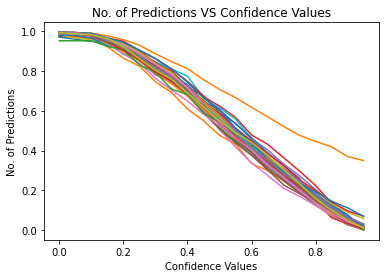

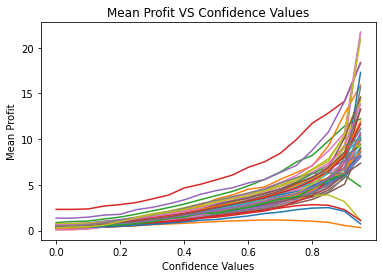

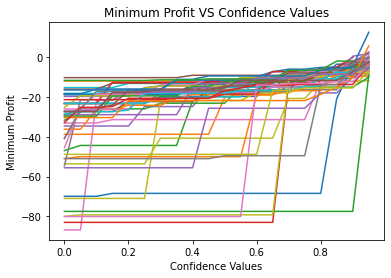

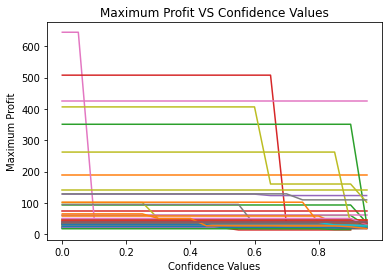

In [22]:
for i in range(len(no_of_decisions)):
    plt.plot([x * 0.01 for x in range(0, 100, 5)], no_of_decisions[i])
    plt.xlabel('Confidence Values') 
    plt.ylabel('No. of Predictions') 
    plt.title('No. of Predictions VS Confidence Values')
plt.show()

for i in range(len(mean_profit)):
    plt.plot([x * 0.01 for x in range(0, 100, 5)], mean_profit[i])
    plt.xlabel('Confidence Values') 
    plt.ylabel('Mean Profit') 
    plt.title('Mean Profit VS Confidence Values')
plt.show()

for i in range(len(min_rofit)):
    plt.plot([x * 0.01 for x in range(0, 100, 5)], min_rofit[i])
    plt.xlabel('Confidence Values') 
    plt.ylabel('Minimum Profit') 
    plt.title('Minimum Profit VS Confidence Values')
plt.show()

for i in range(len(max_profit)):
    plt.plot([x * 0.01 for x in range(0, 100, 5)], max_profit[i])
    plt.xlabel('Confidence Values') 
    plt.ylabel('Maximum Profit') 
    plt.title('Maximum Profit VS Confidence Values')
plt.show()

# Prediction Per Day

In [4]:
chosen_stocks = []
todays_date = datetime.datetime(2022,4,5)
# todays_date = datetime.date.today()

nifty_tickers = get_tickers(2)
i = 0

for t in nifty_tickers:
    try:
        prediction_prob = predict_given_date_ticker(all_model, todays_date, t)  
        if(prediction_prob > 0.85): # Threshold
            print(prediction_prob, t)
            chosen_stocks.append(t)
    except Exception as e:
        print("error with ", t)

0.9359793 ADANIGREEN.NS
0.8540027 AMBUJACEM.NS
0.954243 BAJAJHLDNG.NS
error with  CADILAHC.NS
0.89655924 HAVELLS.NS
error with  MOTHERSUMI.NS
0.8532959 SIEMENS.NS
0.96391875 YESBANK.NS


# Backtest with Realistic Predictions

In [7]:
asdf = realistic_back_test(all_model, 500, 2, 0.9)
asdf

ACC.NS
ABBOTINDIA.NS
ADANIENT.NS
ADANIGREEN.NS
ADANITRANS.NS
ALKEM.NS
AMBUJACEM.NS
APOLLOHOSP.NS
AUROPHARMA.NS
DMART.NS
BAJAJHLDNG.NS
BANDHANBNK.NS
BERGEPAINT.NS
Error with  BIOCON.NS
BOSCHLTD.NS
Error with  CADILAHC.NS
COLPAL.NS
DLF.NS
DABUR.NS
GAIL.NS
GODREJCP.NS
HDFCAMC.NS
HAVELLS.NS
HINDPETRO.NS
ICICIGI.NS
ICICIPRULI.NS
IGL.NS
INDUSTOWER.NS
NAUKRI.NS
INDIGO.NS
JUBLFOOD.NS
LTI.NS
LUPIN.NS
MRF.NS
MARICO.NS
Error with  MOTHERSUMI.NS
MUTHOOTFIN.NS
NMDC.NS
PETRONET.NS
PIDILITIND.NS
PEL.NS
PGHH.NS
PNB.NS
SBICARD.NS
SIEMENS.NS
TORNTPHARM.NS
UBL.NS
MCDOWELL-N.NS
VEDL.NS
YESBANK.NS


,High,Low,Open,Close,Volume,Adj Close,RSI,STOCH14K,STOCH14D,Ticker,Prediction Probability,Buy Signal,Buy Price,Sell Price,Profit,Profit Percentage
Date,,,,,,,,,,,,,,,,
2021-02-15,1798.000000,1766.650024,1785.000000,1788.050049,911884.0,1726.754883,NaN,NaN,NaN,ACC.NS,NaN,0,NaN,NaN,NaN,NaN
2021-02-16,1843.550049,1784.949951,1791.000000,1819.300049,1937730.0,1756.933594,NaN,NaN,NaN,ACC.NS,NaN,0,NaN,NaN,NaN,NaN
2021-02-17,1837.000000,1807.000000,1820.000000,1819.750000,860949.0,1757.368164,NaN,NaN,NaN,ACC.NS,NaN,0,NaN,NaN,NaN,NaN
2021-02-18,1838.099976,1775.150024,1833.099976,1787.900024,634760.0,1726.609985,NaN,NaN,NaN,ACC.NS,NaN,0,NaN,NaN,NaN,NaN
2021-02-19,1801.750000,1735.500000,1800.000000,1747.349976,767848.0,1687.450073,NaN,NaN,NaN,ACC.NS,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-22,12.600000,12.450000,12.600000,12.450000,26497740.0,12.450000,38.670505,16.666679,12.613317,YESBANK.NS,0.594261,0,NaN,NaN,NaN,NaN
2022-06-23,12.650000,12.400000,12.500000,12.450000,27841070.0,12.450000,38.670505,19.658118,16.880346,YESBANK.NS,0.532501,0,NaN,NaN,NaN,NaN
2022-06-24,13.050000,12.500000,12.500000,12.750000,86625594.0,12.750000,46.384349,24.572642,20.299146,YESBANK.NS,0.585843,0,NaN,NaN,NaN,NaN


In [8]:
asdf['Profit Percentage'].describe()

count    477.000000
mean      -0.013155
std        5.285240
min      -16.261332
25%       -2.451024
50%       -0.186194
75%        1.859842
max       32.239153
Name: Profit Percentage, dtype: float64

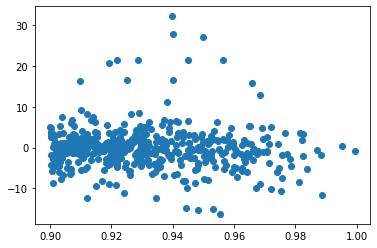

In [9]:
plt.scatter(asdf['Prediction Probability'], asdf['Profit Percentage'])

AAPL
ABNB
ADBE
ADI
ADP
ADSK
AEP
ALGN
AMAT
AMD
AMGN
AMZN
ANSS
ASML
ATVI
AVGO
AZN
BIDU
BIIB
BKNG
CDNS
CEG
CHTR
CMCSA
COST
CPRT
CRWD
CSCO
CSX
CTAS
CTSH
DDOG
DLTR
DOCU
DXCM
EA
EBAY
EXC
FAST
FISV
FTNT
GILD
GOOG
GOOGL
HON
IDXX
ILMN
INTC
INTU
ISRG
JD
KDP
KHC
KLAC
LCID
LRCX
LULU
MAR
MCHP
MDLZ
MELI
META
MNST
MRNA
MRVL
MSFT
MTCH
MU
NFLX
NTES
NVDA
NXPI
ODFL
OKTA
ORLY
PANW
PAYX
PCAR
PDD
PEP
PYPL
QCOM
REGN
ROST
SBUX
SGEN
SIRI
SNPS
SPLK
SWKS
TEAM
TMUS
TSLA
TXN
VRSK
VRSN
VRTX
WBA
WDAY
XEL
ZM
ZS
count    2249.000000
mean        0.171125
std         4.655109
min       -24.714130
25%        -1.940525
50%         0.230888
75%         2.257007
max        36.245400
Name: Profit Percentage, dtype: float64


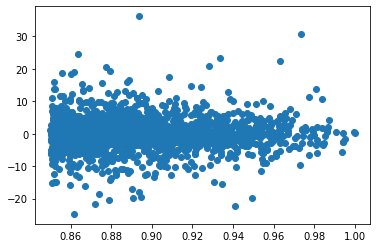

In [55]:
# American Stocks
american_df = realistic_back_test(all_model, 500, 3, 0.85)
print(american_df['Profit Percentage'].describe())
plt.scatter(american_df['Prediction Probability'], american_df['Profit Percentage'])

### The mean values shown in the above cells show that this kind of a model is basically a coin flip. There a minimal gains to be had when using this model even with a very high confidence value. Will be working on a CNN-LSTM, Transformer, etc based model in the future. 

# Experimentation

In [39]:
def get_backtest_df_abhi(mode, ticker_for_backtest, thresh_long, thresh_short, train_start_date, test_end_date, dur = 5):
    pd_datareader_data = data.DataReader(ticker_for_backtest, 'yahoo', train_start_date, test_end_date)
    total = len(pd_datareader_data)
    pd_datareader_data['RSI_14'] = RSI(pd_datareader_data['Close'], timeperiod=14)
    

    if(mode == "ALL"):
        backtest_company_price_data = data_cleaning_for_all_indicators_abhi(pd_datareader_data, 5)
        model = load_model('ALL_model.h5')
    elif(mode == "RSI"):
        backtest_company_price_data = data_cleaning_RSI(pd_datareader_data, 5)
        model = load_model('RSI_Model.h5')
    
    
    #Changing price data to drop rows after creating df
    pd_datareader_data = pd_datareader_data[15 :] # Row mismatch fix requires logic for dropping rows
    # Model prediction on test data
    y_pred_backtest = model.predict(backtest_company_price_data.drop(columns = ['long_or_short']))
    backtest_df = backtest_company_price_data.copy()
    backtest_df['prob_pred'] = y_pred_backtest
    # Creating a column with high confidence outputs for long/short
    backtest_df['thresh_signal'] = backtest_df['prob_pred'].apply(lambda x: 1 if x > thresh_long else (0 if x < thresh_short else np.nan))
    backtest_df.reset_index(inplace = True, drop = True)
    high_conf_stats =  backtest_df[['thresh_signal', 'long_or_short']].dropna()
#     print("\nPredictions of high confidence = ", 
#           len(high_conf_stats), "\n")
#     print("\nClassification Report", classification_report(high_conf_stats['long_or_short'],
#                             high_conf_stats['thresh_signal']), "\n")
    
    
    high_conf_colormap = []
    buy_sell_signal_from_model = []
    for s in backtest_df['thresh_signal'].values:
        if (s == 0.0):
            for i in range(1):
                high_conf_colormap.append('k')
                buy_sell_signal_from_model.append(0)
        elif(s == 1.0):
            for i in range(1):
                high_conf_colormap.append('y')
                buy_sell_signal_from_model.append(1)
        else:
            for i in range(1):
                high_conf_colormap.append('b')
                buy_sell_signal_from_model.append(np.nan)

    
    # Fix for df shape mismatch
    row_mismatch_count = pd_datareader_data.shape[0] - len(buy_sell_signal_from_model)
    pd_datareader_data = pd_datareader_data[ : -row_mismatch_count]
    pd_datareader_data['buy_sell_signal_from_model'] = buy_sell_signal_from_model
    
    # Profit/Loss calculation for long signals
    profit_long = []
    buy_price = []
    sell_price = []
    
    for i in range(len(pd_datareader_data) - dur):
        if(pd_datareader_data.iloc[i]['buy_sell_signal_from_model'] == 1.0):
            profit = pd_datareader_data.iloc[i + dur]['Close'] - pd_datareader_data.iloc[i + 1]['Close']
            profit_long.append(profit)
            buy_price.append(pd_datareader_data.iloc[i + 1]['Close'])
            sell_price.append(pd_datareader_data.iloc[i + dur]['Close'])
        else:
            profit_long.append(np.nan)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            
    # For the last "dur" days we cannot get a profit since those days dont exist. Hence just adding nans. 
    for i in range(dur):
        profit_long.append(np.nan)
        buy_price.append(np.nan)
        sell_price.append(np.nan)

    pd_datareader_data['profit_long'] = profit_long
    pd_datareader_data['buy_price'] = buy_price
    pd_datareader_data['sell_price'] = sell_price
    pd_datareader_data['profit_percentage_per_trade'] = (pd_datareader_data['sell_price'] - pd_datareader_data['buy_price']) / pd_datareader_data['buy_price'] * 100
    return(pd_datareader_data[pd_datareader_data['buy_sell_signal_from_model'] == 1], total)


In [56]:
asdf, a = get_backtest_df_abhi("ALL", "INFY.NS", 
                       0.8, 0.5, 
                       train_start_date, 
                       datetime.datetime(2022,5,24), 
                       5)

10 1
15 6
20 11
25 16
30 21
35 26
40 31
45 36
50 41
55 46
60 51
65 56
70 61
75 66
80 71
85 76
90 81
95 86
100 91
105 96
110 101
115 106
120 111
125 116
130 121
135 126
140 131
145 136
150 141
155 146
160 151
165 156
170 161
175 166
180 171
185 176
190 181
195 186
200 191
205 196
210 201
215 206
220 211
225 216
230 221
235 226
240 231
245 236
250 241
255 246
260 251
265 256
270 261
275 266
280 271
285 276
290 281
295 286
300 291
305 296
310 301
315 306
320 311
325 316
330 321
335 326
340 331
345 336
350 341
355 346
360 351
365 356
370 361
375 366
380 371
385 376
390 381
395 386
400 391
405 396
410 401
415 406
420 411
425 416
430 421
435 426
440 431
445 436
450 441
455 446
460 451
465 456
470 461
475 466
480 471
485 476
490 481
495 486
500 491
505 496
510 501
515 506
520 511
525 516
530 521
535 526
540 531
545 536
550 541
555 546
560 551
565 556
570 561
575 566
580 571
585 576
590 581
595 586
600 591
605 596
610 601
615 606
620 611
625 616
630 621
635 626
640 631
645 636
650 641
655 646


In [49]:
# asdf = asdf.iloc[4: : 5]
# asdf

In [57]:
asdf['profit_percentage_per_trade'].mean()

4.296099160393432

In [58]:
asdf[asdf['buy_sell_signal_from_model'] == 1]

,High,Low,Open,Close,Volume,Adj Close,RSI_14,buy_sell_signal_from_model,profit_long,buy_price,sell_price,profit_percentage_per_trade
Date,,,,,,,,,,,,
1996-01-24,0.770507,0.752929,0.773925,0.770507,409600.0,0.526763,37.946161,1.0,0.013672,0.767578,0.781250,1.781186
1996-01-25,0.770996,0.767578,0.770996,0.767578,102400.0,0.524760,36.648004,1.0,0.042968,0.767578,0.810546,5.597864
1996-01-26,0.767578,0.767578,0.767578,0.767578,0.0,0.524760,36.648004,1.0,0.076563,0.763183,0.839746,10.032063
1996-01-29,0.765625,0.763183,0.765625,0.763183,102400.0,0.521756,34.588757,1.0,0.067383,0.772460,0.839843,8.723169
1996-02-02,0.839843,0.810546,0.810546,0.839746,2355200.0,0.574099,70.641245,1.0,0.082715,0.839843,0.922558,9.848869
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,1808.000000,1776.000000,1795.000000,1785.699951,8252758.0,1785.699951,40.070210,1.0,-0.600098,1736.800049,1736.199951,-0.034552
2022-01-24,1768.650024,1728.000000,1765.000000,1736.800049,7116712.0,1736.800049,34.579623,1.0,49.900024,1722.150024,1772.050049,2.897542
2022-02-28,1728.050049,1665.000000,1682.199951,1715.599976,15076542.0,1715.599976,45.973248,1.0,75.399902,1702.800049,1778.199951,4.427995


In [59]:
asdf

,High,Low,Open,Close,Volume,Adj Close,RSI_14,buy_sell_signal_from_model,profit_long,buy_price,sell_price,profit_percentage_per_trade
Date,,,,,,,,,,,,
1996-01-24,0.770507,0.752929,0.773925,0.770507,409600.0,0.526763,37.946161,1.0,0.013672,0.767578,0.781250,1.781186
1996-01-25,0.770996,0.767578,0.770996,0.767578,102400.0,0.524760,36.648004,1.0,0.042968,0.767578,0.810546,5.597864
1996-01-26,0.767578,0.767578,0.767578,0.767578,0.0,0.524760,36.648004,1.0,0.076563,0.763183,0.839746,10.032063
1996-01-29,0.765625,0.763183,0.765625,0.763183,102400.0,0.521756,34.588757,1.0,0.067383,0.772460,0.839843,8.723169
1996-02-02,0.839843,0.810546,0.810546,0.839746,2355200.0,0.574099,70.641245,1.0,0.082715,0.839843,0.922558,9.848869
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,1808.000000,1776.000000,1795.000000,1785.699951,8252758.0,1785.699951,40.070210,1.0,-0.600098,1736.800049,1736.199951,-0.034552
2022-01-24,1768.650024,1728.000000,1765.000000,1736.800049,7116712.0,1736.800049,34.579623,1.0,49.900024,1722.150024,1772.050049,2.897542
2022-02-28,1728.050049,1665.000000,1682.199951,1715.599976,15076542.0,1715.599976,45.973248,1.0,75.399902,1702.800049,1778.199951,4.427995


In [60]:
a

6641

In [61]:
get_backtest_stats(asdf)

{'total_length_of_data': 1030,
 'length_of_high_confidence_data': 1030,
 'mean_profit_per_trade': 4.296099160393432,
 'layman_profit': 223557.9418427934,
 'returns': 1.8597751064125804e+20}

In [13]:
pd_datareader_data = data.DataReader('AAPL', 'yahoo', train_start_date, test_end_date)
pd_datareader_data['RSI_14'] = RSI(pd_datareader_data['Close'], timeperiod=14)
    


backtest_company_price_data = data_cleaning_for_all_indicators_abhi(pd_datareader_data, 5)
backtest_company_price_data

,rsi0,rsi1,rsi2,rsi3,rsi4,stochk0,stochk1,stochk2,stochk3,stochk4,...,stochd1,stochd2,stochd3,stochd4,close0,close1,close2,close3,close4,long_or_short
0,52.376308,56.819433,55.954525,52.110399,52.500873,50.436016,44.324026,38.320328,27.019217,13.802802,...,52.843555,44.360123,36.554524,26.380782,0.135045,0.142299,0.141183,0.136161,0.136719,1.0
1,56.819433,55.954525,52.110399,52.500873,54.498568,44.324026,38.320328,27.019217,13.802802,9.219494,...,44.360123,36.554524,26.380782,16.680504,0.142299,0.141183,0.136161,0.136719,0.139509,1.0
2,55.954525,52.110399,52.500873,54.498568,53.528777,38.320328,27.019217,13.802802,9.219494,12.056266,...,36.554524,26.380782,16.680504,11.692854,0.141183,0.136161,0.136719,0.139509,0.138393,0.0
3,52.110399,52.500873,54.498568,53.528777,59.368572,27.019217,13.802802,9.219494,12.056266,27.427904,...,26.380782,16.680504,11.692854,16.234555,0.136161,0.136719,0.139509,0.138393,0.146763,1.0
4,52.500873,54.498568,53.528777,59.368572,55.372003,13.802802,9.219494,12.056266,27.427904,33.790781,...,16.680504,11.692854,16.234555,24.424984,0.136719,0.139509,0.138393,0.146763,0.142299,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10414,34.680043,46.628192,39.959143,40.433987,42.821693,9.789935,19.152474,23.679995,30.035360,24.582989,...,12.365044,17.540801,24.289276,26.099448,156.570007,163.639999,157.649994,157.960007,159.479996,NaN
10415,46.628192,39.959143,40.433987,42.821693,51.778367,19.152474,23.679995,30.035360,24.582989,43.172693,...,17.540801,24.289276,26.099448,32.597014,163.639999,157.649994,157.960007,159.479996,166.020004,NaN
10416,39.959143,40.433987,42.821693,51.778367,41.804073,23.679995,30.035360,24.582989,43.172693,41.000362,...,24.289276,26.099448,32.597014,36.252015,157.649994,157.960007,159.479996,166.020004,156.770004,NaN
10417,40.433987,42.821693,51.778367,41.804073,42.462179,30.035360,24.582989,43.172693,41.000362,36.984302,...,26.099448,32.597014,36.252015,40.385785,157.960007,159.479996,166.020004,156.770004,157.279999,NaN


In [14]:
backtest_company_price_data.head(30)

,rsi0,rsi1,rsi2,rsi3,rsi4,stochk0,stochk1,stochk2,stochk3,stochk4,...,stochd1,stochd2,stochd3,stochd4,close0,close1,close2,close3,close4,long_or_short
0,52.376308,56.819433,55.954525,52.110399,52.500873,5.043602e+01,4.432403e+01,3.832033e+01,2.701922e+01,1.380280e+01,...,52.843555,44.360123,36.554524,26.380782,0.135045,0.142299,0.141183,0.136161,0.136719,1.0
1,56.819433,55.954525,52.110399,52.500873,54.498568,4.432403e+01,3.832033e+01,2.701922e+01,1.380280e+01,9.219494e+00,...,44.360123,36.554524,26.380782,16.680504,0.142299,0.141183,0.136161,0.136719,0.139509,1.0
2,55.954525,52.110399,52.500873,54.498568,53.528777,3.832033e+01,2.701922e+01,1.380280e+01,9.219494e+00,1.205627e+01,...,36.554524,26.380782,16.680504,11.692854,0.141183,0.136161,0.136719,0.139509,0.138393,0.0
3,52.110399,52.500873,54.498568,53.528777,59.368572,2.701922e+01,1.380280e+01,9.219494e+00,1.205627e+01,2.742790e+01,...,26.380782,16.680504,11.692854,16.234555,0.136161,0.136719,0.139509,0.138393,0.146763,1.0
4,52.500873,54.498568,53.528777,59.368572,55.372003,1.380280e+01,9.219494e+00,1.205627e+01,2.742790e+01,3.379078e+01,...,16.680504,11.692854,16.234555,24.424984,0.136719,0.139509,0.138393,0.146763,0.142299,0.0
5,54.498568,53.528777,59.368572,55.372003,57.306456,9.219494e+00,1.205627e+01,2.742790e+01,3.379078e+01,4.620146e+01,...,11.692854,16.234555,24.424984,35.806715,0.139509,0.138393,0.146763,0.142299,0.145089,0.0
6,53.528777,59.368572,55.372003,57.306456,58.469647,1.205627e+01,2.742790e+01,3.379078e+01,4.620146e+01,5.283868e+01,...,16.234555,24.424984,35.806715,44.276974,0.138393,0.146763,0.142299,0.145089,0.146763,0.0
7,59.368572,55.372003,57.306456,58.469647,57.903330,2.742790e+01,3.379078e+01,4.620146e+01,5.283868e+01,6.978774e+01,...,24.424984,35.806715,44.276974,56.275960,0.146763,0.142299,0.145089,0.146763,0.146205,0.0
8,55.372003,57.306456,58.469647,57.903330,55.584215,3.379078e+01,4.620146e+01,5.283868e+01,6.978774e+01,7.631029e+01,...,35.806715,44.276974,56.275960,66.312236,0.142299,0.145089,0.146763,0.146205,0.143973,0.0
9,57.306456,58.469647,57.903330,55.584215,54.410790,4.620146e+01,5.283868e+01,6.978774e+01,7.631029e+01,7.246369e+01,...,44.276974,56.275960,66.312236,72.853906,0.145089,0.146763,0.146205,0.143973,0.142857,0.0


In [15]:
pd_datareader_data.dropna().head(20)

,High,Low,Open,Close,Volume,Adj Close,RSI_14
Date,,,,,,,
1981-01-05,0.151228,0.150670,0.151228,0.150670,35728000.0,0.118289,64.493312
1981-01-06,0.144531,0.143973,0.144531,0.143973,45158400.0,0.113032,58.970446
1981-01-07,0.138393,0.137835,0.138393,0.137835,55686400.0,0.108213,54.374496
1981-01-08,0.135603,0.135045,0.135603,0.135045,39827200.0,0.106022,52.376308
1981-01-09,0.142857,0.142299,0.142299,0.142299,21504000.0,0.111717,56.819433
1981-01-12,0.142299,0.141183,0.142299,0.141183,23699200.0,0.110841,55.954525
1981-01-13,0.136719,0.136161,0.136719,0.136161,23049600.0,0.106898,52.110399
1981-01-14,0.137277,0.136719,0.136719,0.136719,14291200.0,0.107337,52.500873
1981-01-15,0.140625,0.139509,0.139509,0.139509,14067200.0,0.109527,54.498568


In [16]:
backtest_company_price_data['long_or_short'].value_counts()

1.0    5686
0.0    4728
Name: long_or_short, dtype: int64